In [1840]:
import SimFunctions
import SimClasses
import SimRNG_Modified
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import probplot, kstest, t
import pickle
from copy import deepcopy

warnings.filterwarnings("ignore")
np.random.seed(1)
ZSimRNG = SimRNG_Modified.InitializeRNSeed()


# Data Loading & Preprocessing 

In [1393]:
#subset_df = pd.read_csv("10_station_subset.csv")
subset_df = pd.read_csv("top20_station_subset.csv")
subset_df['End Station Id'] = subset_df['End Station Id'].astype(int)


In [1394]:
subset_df.head()

,Unnamed: 0,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips,Start Time (per 30min),End Time (per 30min),Start Time (minutes),End Time (minutes)
0,0,17515475,29.566667,7203,2022-08-01 00:02:00,Bathurst St/Queens Quay(Billy Bishop Airport),7261,2022-08-01 00:32:00,Queens Quay E / Lower Sherbourne St,6908,Casual Member,72,0.0,1.0,2,32
1,18537,17961013,13.583333,7006,2022-08-18 00:14:00,Bay St / College St (East Side),7217,2022-08-18 00:28:00,Soho St / Queen St W,5958,Casual Member,49,0.0,0.0,14,28
2,18536,17961003,14.216667,7006,2022-08-18 00:13:00,Bay St / College St (East Side),7217,2022-08-18 00:27:00,Soho St / Queen St W,2635,Annual Member,49,0.0,0.0,13,27
3,11661,18045153,16.400000,7298,2022-08-21 00:24:00,Bathurst St / Adelaide St W,7076,2022-08-21 00:41:00,York St / Queens Quay W,641,Annual Member,14,0.0,1.0,24,41
4,11660,18013115,17.833333,7298,2022-08-20 00:10:00,Bathurst St / Adelaide St W,7076,2022-08-20 00:28:00,York St / Queens Quay W,3264,Casual Member,14,0.0,0.0,10,28


In [1396]:
len(subset_df["Start Station Name"].value_counts())

19

## Arrival Rates

In [569]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by station and 30-minute interval, and count the number of trips that started in each group
Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'],subset_df['Start Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')
#Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')

# Calculate the arrival rate at each station and 30-minute interval (trips per hour)
Start_Station_HalfHour_Arrivals['ArrivalRate (per min)'] = Start_Station_HalfHour_Arrivals['ArrivalRate (per 30min)'] / 30

# Display the result
arrival_df = Start_Station_HalfHour_Arrivals.sort_values(by="Start Time (per 30min)")
arrival_df


,Start Station Name,Start Station Id,Start Time (per 30min),ArrivalRate (per 30min),ArrivalRate (per min)
0,Bathurst St / Adelaide St W,7298,0.0,9,0.300000
787,York St / Queens Quay W,7076,0.0,12,0.400000
92,Bay St / College St (East Side),7006,0.0,8,0.266667
744,Union Station,7033,0.0,2,0.066667
134,Bay St / Queens Quay W (Ferry Terminal),7016,0.0,9,0.300000
...,...,...,...,...,...
133,Bay St / College St (East Side),7006,47.0,4,0.133333
743,Soho St / Queen St W,7217,47.0,3,0.100000
91,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,27,0.900000
609,Queens Quay / Yonge St,7168,47.0,13,0.433333


In [570]:
desc = arrival_df.describe()[1:2].values
mean_arrival_30 = desc[0][2]
mean_arrival_min = desc[0][3]

customer_per_30min = mean_arrival_30
customer_per_min = mean_arrival_min
print(f"Customers Per 30 min = {customer_per_30min}")
print(f"Customers Per min = {customer_per_min}")


Customers Per 30 min = 22.92436974789916
Customers Per min = 0.7641456582633053


- There is approx 0.10 customer every minute in the dataset or 1 customer every 10min

## Probability of Destinations

- After finding the probabilities of arriving to a destination from a specific stations, I filled any NA with 0.01 and then normalized to account for random arrivals to different destinations that was not in the data

In [571]:
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

start_end_station_halfhour_trips = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='NumOfTrips')
total_trips = start_end_station_halfhour_trips.groupby(['Start Station Name', 'Start Time (per 30min)'])['NumOfTrips'].sum().reset_index(name='TotalTrips')

start_end_station_prob = pd.merge(start_end_station_halfhour_trips, total_trips, on=['Start Station Name', 'Start Time (per 30min)'])
start_end_station_prob['Probability'] = start_end_station_prob['NumOfTrips'] / start_end_station_prob['TotalTrips']

station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Name', 'Start Time (per 30min)'], columns=['End Station Name'], values='Probability').fillna(0)
name_prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
name_prob_df.head()

,End Station Name,Bathurst St / Adelaide St W,Bathurst St/Queens Quay(Billy Bishop Airport),Bay St / College St (East Side),Bay St / Queens Quay W (Ferry Terminal),Bay St / Wellesley St W,College St / Major St,Fort York Blvd / Capreol Ct,HTO Park (Queens Quay W),King St W / Brant St,Lake Shore Blvd W / Ontario Dr,Lower Jarvis / Queens Quay E,Marilyn Bell Park Tennis Court,Ontario Place Blvd / Lake Shore Blvd W (East),Queens Quay / Yonge St,Queens Quay E / Lower Sherbourne St,Queens Quay W / Lower Simcoe St,Soho St / Queen St W,Union Station,York St / Queens Quay W
Start Station Name,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
Bathurst St / Adelaide St W,0.0,0.222222,0.000000,0.222222,0.0,0.222222,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.111111,0.000000,0.222222
York St / Queens Quay W,0.0,0.083333,0.000000,0.000000,0.0,0.083333,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.250,0.000000,0.166667,0.000000,0.000000,0.333333
Bay St / College St (East Side),0.0,0.125000,0.000000,0.125000,0.0,0.000000,0.0,0.125000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.000000,0.000000,0.250000,0.250000,0.000000
Union Station,0.0,0.000000,0.000000,0.000000,0.0,0.500000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.000000
Bay St / Queens Quay W (Ferry Terminal),0.0,0.000000,0.111111,0.000000,0.0,0.000000,0.0,0.000000,0.111111,0.0,0.0,0.111111,0.0,0.111111,0.000,0.222222,0.000000,0.000000,0.333333,0.000000


Real Probability
End Station Name
Bathurst St / Adelaide St W                      0.0
Bathurst St/Queens Quay(Billy Bishop Airport)    0.0
Bay St / College St (East Side)                  0.1
Bay St / Queens Quay W (Ferry Terminal)          0.0
Bay St / Wellesley St W                          0.0
College St / Major St                            0.0
Fort York  Blvd / Capreol Ct                     0.0
HTO Park (Queens Quay W)                         0.0
King St W / Brant St                             0.1
Lake Shore Blvd W / Ontario Dr                   0.2
Lower Jarvis / Queens Quay E                     0.0
Marilyn Bell Park Tennis Court                   0.5
Ontario Place Blvd / Lake Shore Blvd W (East)    0.0
Queens Quay / Yonge St                           0.0
Queens Quay E / Lower Sherbourne St              0.0
Queens Quay W / Lower Simcoe St                  0.1
Soho St / Queen St W                             0.0
Union Station                                    0.0
York St / Qu

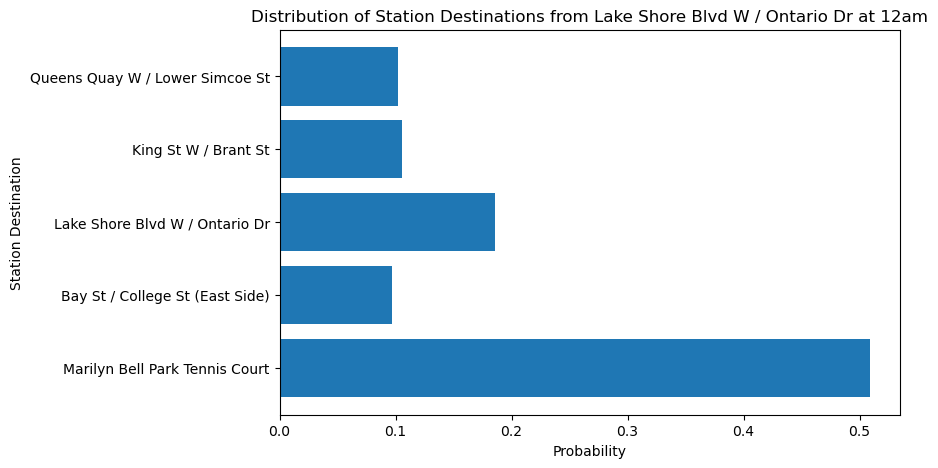

In [572]:
def ChoosingRoute(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(1000):
    start_station = 'Lake Shore Blvd W / Ontario Dr'
    start_time = 0  # 30-minute interval index
    destination = ChoosingRoute(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at 12am')
plt.show()


Real Probability
End Station Name
Bathurst St / Adelaide St W                      0.000000
Bathurst St/Queens Quay(Billy Bishop Airport)    0.000000
Bay St / College St (East Side)                  0.000000
Bay St / Queens Quay W (Ferry Terminal)          0.161290
Bay St / Wellesley St W                          0.000000
College St / Major St                            0.000000
Fort York  Blvd / Capreol Ct                     0.096774
HTO Park (Queens Quay W)                         0.161290
King St W / Brant St                             0.032258
Lake Shore Blvd W / Ontario Dr                   0.129032
Lower Jarvis / Queens Quay E                     0.064516
Marilyn Bell Park Tennis Court                   0.129032
Ontario Place Blvd / Lake Shore Blvd W (East)    0.032258
Queens Quay / Yonge St                           0.064516
Queens Quay E / Lower Sherbourne St              0.032258
Queens Quay W / Lower Simcoe St                  0.032258
Soho St / Queen St W                  

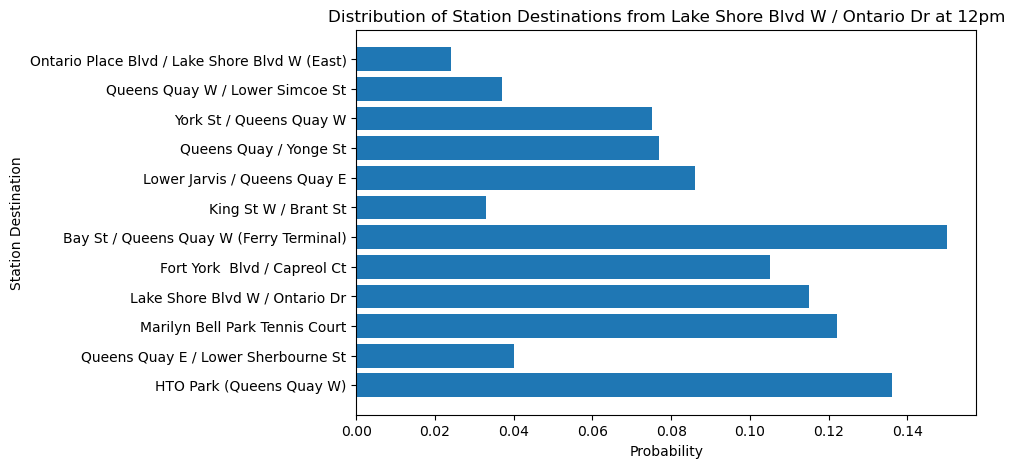

In [573]:
def ChoosingRoute(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(1000):
    start_station = 'Lake Shore Blvd W / Ontario Dr'
    start_time = 24  # 30-minute interval index
    destination = ChoosingRoute(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at {start_time//2}pm')
plt.show()


In [574]:
station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Id', 'Start Time (per 30min)'], columns=['End Station Id'], values='Probability').fillna(0)
prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
prob_df


,End Station Id,7000,7006,7016,7030,7033,7043,7076,7078,7168,7171,7175,7203,7217,7242,7261,7298,7322,7399,7430
Start Station Id,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
7000,0.0,0.000000,0.000000,0.0,0.0,1.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
7006,0.0,0.125000,0.125000,0.0,0.0,0.25,0.0,0.000000,0.0,0.125000,0.0,0.0,0.000000,0.250000,0.0,0.000000,0.125000,0.000000,0.000000,0.0
7399,0.0,0.000000,0.000000,0.0,0.0,0.00,0.2,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.200000,0.000000,0.000000,0.400000,0.0
7033,0.0,0.000000,0.000000,0.0,0.5,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.0
7261,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.166667,0.0,0.333333,0.0,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006,47.0,0.500000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
7322,47.0,0.285714,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.142857,0.428571,0.142857,0.0
7000,47.0,0.333333,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.0,0.333333,0.000000,0.000000,0.000000,0.0


## Trip Durations

### Different Stations Destinations

In [575]:
with open('top20_diff_google_bike_trip_est.pickle', 'rb') as f:
    google_bike_trip = pickle.load(f)

diff_stations_subset_df = pd.read_csv("diff_stations_subset_df.csv")
google = pd.DataFrame((np.array(google_bike_trip)), columns=["Google"])
observed = pd.DataFrame(np.array((diff_stations_subset_df["Trip_Duration"].values)), columns=["Observed"])
trip_reg_df = pd.DataFrame({"Observed": np.array((diff_stations_subset_df["Trip_Duration"].values)*60), "Google": np.array(google_bike_trip)})
trip_reg_df.head()


,Observed,Google
0,1774.0,582
1,1761.0,582
2,1098.0,582
3,892.0,582
4,1310.0,582


In [576]:
trip_reg_df.describe()


,Observed,Google
count,16202.000000,16202.000000
mean,892.046599,455.499198
std,459.080990,274.908215
min,64.000000,34.000000
25%,504.000000,249.000000
50%,841.500000,421.000000
75%,1246.000000,644.000000
max,1980.000000,1521.000000


Error Mean -1.5261626468615904e-16
Residual Variance: 0.25580459588191384

Beta: 0.4513542745881248
Intercept: 3.974270551809947
R^2: 0.3143043103068821


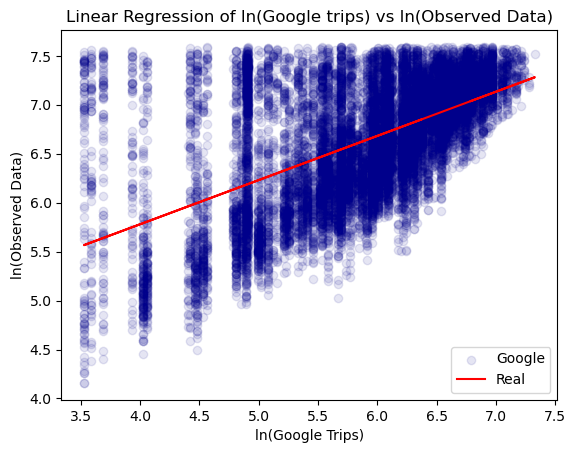

In [577]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
predictions = model.predict(X)
score = model.score(X, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_var = np.var(residuals)
residual_mean = np.mean(residuals)

print("Error Mean", residual_mean)
print("Residual Variance:", residual_var)
print()
print('Beta:', beta)
print('Intercept:', intercept)
print("R^2:", score)

plt.scatter(X, y, color='darkblue', alpha=0.1)
plt.plot(X, predictions, color='red')
plt.title("Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


Pre Residual Mean -1.5261626468615904e-16
Pre Residual Variance: 0.25580459588191384

New Resiudal Mean -5.530146832449613e-16
New Residual Variance: 0.12858666740184382

Beta: 0.47504569391691565
Intercept: 3.8372405086866
R^2: 0.6553176721259963


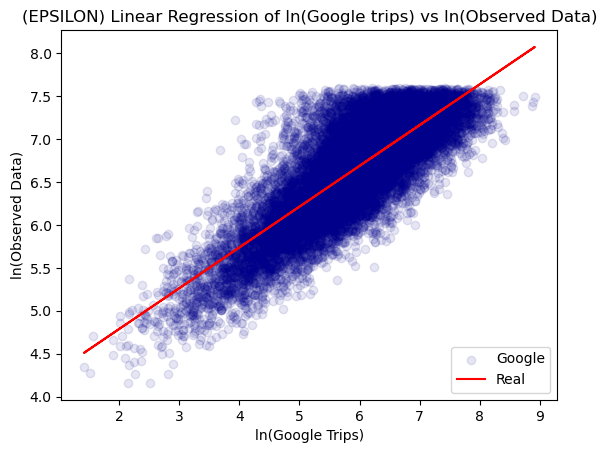

In [578]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X_i = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X_i, y)
predictions = model.predict(X_i)
score = model.score(X_i, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_mean = np.mean(residuals)
residual_var = np.var(residuals)
residual_std = np.std(residuals)

error_sd = np.sqrt(residual_var)
errors = np.random.normal(loc=residual_mean, scale=residual_std, size=len(residuals))
epsilon = residuals - errors

new_X = X + epsilon
new_X_i = np.array(new_X).reshape(-1, 1)

# Fit linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(new_X_i, y)
new_predictions = model.predict(new_X_i)

# Calculate R-squared and print results
r2 = model.score(new_X_i, y)
new_beta = model.coef_[0]
new_intercept = model.intercept_

new_residuals = y - new_predictions
new_residual_mean = np.mean(new_residuals)
new_residual_var = np.var(new_residuals)
new_residual_std = np.std(new_residuals)
print("Pre Residual Mean", residual_mean)
print("Pre Residual Variance:", residual_var)
print()

print("New Resiudal Mean", new_residual_mean)
print("New Residual Variance:", new_residual_var)
print()
print('Beta:', new_beta)
print('Intercept:', new_intercept)
print("R^2:", r2)

plt.scatter(new_X_i, y, color='darkblue', alpha=0.1)
plt.plot(new_X_i, new_predictions, color='red')
plt.title("(EPSILON) Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


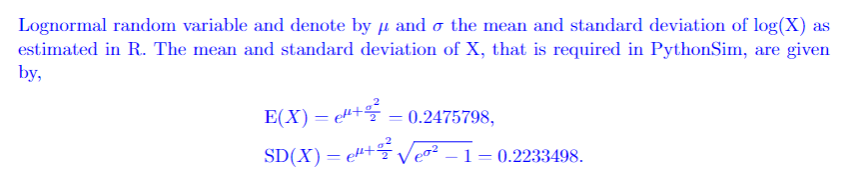

In [579]:
global E_x, SD_X

u = residual_mean
std = np.sqrt(residual_var)
E_x = np.exp(u + ((std**2)/2))
SD_x = np.exp(u + ((std**2)/2)) * np.sqrt(np.exp(std**2) - 1)
print(E_x, SD_x)


1.1364419645529011 0.6135737822915353


### Same Start and End Destination

In [580]:
same_stations_subset_df = pd.read_csv("same_stations_subset_df.csv")
same_stations_subset_df

,Unnamed: 0,index,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips
0,0,88,17515597,1.250000,7261,08/01/2022 00:12,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 00:13,Queens Quay E / Lower Sherbourne St,1815,Casual Member,156
1,1,90,17520082,20.633333,7261,08/01/2022 10:37,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 10:58,Queens Quay E / Lower Sherbourne St,5739,Annual Member,156
2,2,91,17520873,25.416667,7261,08/01/2022 11:18,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 11:43,Queens Quay E / Lower Sherbourne St,5090,Casual Member,156
3,3,92,17527065,1.533333,7261,08/01/2022 14:46,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 14:48,Queens Quay E / Lower Sherbourne St,2183,Casual Member,156
4,4,93,17528090,5.766667,7261,08/01/2022 15:16,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 15:22,Queens Quay E / Lower Sherbourne St,6707,Annual Member,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,2889,20478,18195862,26.833333,7006,08/27/2022 13:32,Bay St / College St (East Side),7006.0,08/27/2022 13:58,Bay St / College St (East Side),4243,Casual Member,46
2890,2890,20479,18214675,32.016667,7006,08/27/2022 21:53,Bay St / College St (East Side),7006.0,08/27/2022 22:25,Bay St / College St (East Side),295,Casual Member,46
2891,2891,20481,18277866,25.800000,7006,08/30/2022 16:13,Bay St / College St (East Side),7006.0,08/30/2022 16:39,Bay St / College St (East Side),4007,Casual Member,46
2892,2892,20482,18289543,1.016667,7006,08/30/2022 23:16,Bay St / College St (East Side),7006.0,08/30/2022 23:17,Bay St / College St (East Side),5573,Casual Member,46


### Average Trip Durations between Specific Stations

In [581]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by start and end station and 30-minute interval, and calculate the average trip duration in seconds for each group
Station_HalfHour_AvgDuration = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']])['Trip_Duration'].mean().reset_index(name='Avg_Trip_Duration')

Station_HalfHour_AvgDuration['Avg_Trip_Duration'] = Station_HalfHour_AvgDuration['Avg_Trip_Duration']

avg_trip_duration = Station_HalfHour_AvgDuration.sort_values(by="Start Time (per 30min)")
avg_trip_duration


,Start Station Name,Start Station Id,End Station Name,End Station Id,Start Time (per 30min),Avg_Trip_Duration
0,Bathurst St / Adelaide St W,7298,Bathurst St / Adelaide St W,7298,0.0,5.691667
4287,Queens Quay / Yonge St,7168,Queens Quay / Yonge St,7168,0.0,25.391667
4211,Queens Quay / Yonge St,7168,Lower Jarvis / Queens Quay E,7399,0.0,2.950000
758,Bay St / College St (East Side),7006,Fort York Blvd / Capreol Ct,7000,0.0,17.850000
4068,Queens Quay / Yonge St,7168,Bathurst St/Queens Quay(Billy Bishop Airport),7203,0.0,10.508333
...,...,...,...,...,...,...
1284,Bay St / Wellesley St W,7030,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,23.950000
5379,Union Station,7033,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,20.500000
2572,King St W / Brant St,7322,Lower Jarvis / Queens Quay E,7399,47.0,26.200000
2743,Lake Shore Blvd W / Ontario Dr,7242,Bay St / College St (East Side),7006,47.0,22.466667


In [582]:
avg_trip_duration["Avg_Trip_Duration"].describe()


count    6124.000000
mean       14.446534
std         6.952742
min         1.016667
25%         8.966667
50%        14.012500
75%        19.360417
max        33.000000
Name: Avg_Trip_Duration, dtype: float64

# Classes & Functions

## Classes

- Decide on the time units
    - Min 

In [1766]:
class Station:
    def __init__(self, station_id, level, capacity):
        self.id = station_id
        self.level = level
        self.capacity = capacity
        self.bikes = {}
        self.bike_list = []
        for i in range(level):
            bike_id = f"{station_id}-{i+1}"  # create unique bike ID
            self.bikes[bike_id] = True  # mark bike as available
            self.bike_list.append(bike_id)

    def rent_bike(self):
        # Request a bike from the station
        if self.level > 0:
            if self.bike_list:
                random_index = np.random.randint(0, len(self.bike_list))
                bike_id = self.bike_list.pop(random_index)
                self.level -= 1
                return bike_id
        return None

    def return_bike(self, bike_id):
        # # Return a bike to the station
        if self.level < self.capacity:
            self.bike_list.append(bike_id)
            self.level += 1

    def Get_Bike_List(self):
        return self.bike_list


class Customer:
    def __init__(self, customer_id, start_s_id, bike=None):
        self.customer_id = customer_id
        self.start_s_id = start_s_id
        self.end_s_id = 0
        self.station_level = 0
        self.bike = bike
        self.T = 0
        self.time = 0
        self.Min = None
        self.Trip_Time = 0

    def rent_bike(self):
        station = StationDict[self.start_s_id]
        #print(f"   Customer Arrives at S{station.id} with Level: {station.level}")

        if station.level > 0:
            self.bike = station.rent_bike()
            self.station_level = station.level
            #print(f"    [Customer Rent Bikes] Customer ID: {self.customer_id} | Bike ID {self.bike} || Start Time: {self.T}:{self.Min} || From: S{self.start_s_id} -> Remaining Level: {self.station_level}")
            self.Departure()
        #else:
            #print(f"    -   (EMPTY) -- Customer {self.customer_id} CANNOT RENT BIKE -- EMPTY STATION {self.start_s_id} w/ level {self.station_level} -- (EMPTY)")

    def return_bike(self, end_station, bike):
        destination_station = StationDict[end_station]
        destination_station.return_bike(bike)
        self.station_level = destination_station.level
    
    def Departure(self):
        self.end_s_id = int(self.Destination())
        end_station = StationDict[self.end_s_id]
        
        trip_time = self.TripDuration()
        self.Trip_Time = trip_time
        
        # print(f"        [Customer Rents Bike and Departs]: Customer ID: {self.customer_id} | Bike ID: {self.bike}")
        # print(f"            - Start Time:{self.time}:{self.Min}")
        # print(f"            - From: S{self.start_s_id} -> Level {self.station_level} | To: S{end_station.id} -> Level {end_station.level}")
        # print(f"            - Expected Trip Time: {self.Trip_Time} min")
        
        SimFunctions.Schedule(Calendar, "Bike_Arrival", trip_time)
        return self.end_s_id
    

######
#HELPER FUNCTIONS
######
    def Destination(self):
        end_s_id = None
        while end_s_id is None:
            end_s_id = self.ChoosingRoute(prob_df, start_s_id=self.start_s_id, start_time=self.T)
        return end_s_id


    def ChoosingRoute(self, prob_df, start_s_id, start_time):
        while True:
            try:
                start_row = prob_df.loc[(start_s_id, max(0, start_time))]
                probs = start_row.values
                end_s_id = np.random.choice(start_row.index, p=probs)
                return end_s_id

            except KeyError:
                print(f"NO DATA found for start station: '{start_s_id}' and start T: '{start_time}'")
                start_time -= 1
                if start_time < 0:  # Optional: Add this line to prevent an infinite loop if data is never found
                    return start_s_id


    def TripDuration(self):
        
        if self.start_s_id == self.end_s_id: #sample from empherical df if same start and end station
            time_df = subset_df[subset_df["Start Time (per 30min)"] == self.T]
            same_station_subset = time_df.loc[time_df['Start Station Id'] == time_df['End Station Id']]['Trip_Duration'].values
            duration_data = np.random.choice(same_station_subset)
            
        else:
            T = self.T
            while True:
                try:
                duration_data = avg_trip_duration[(avg_trip_duration["Start Time (per 30min)"] == T) &
                                            (avg_trip_duration["Start Station Id"] == self.start_s_id) &
                                            (avg_trip_duration["End Station Id"] == self.end_s_id)]["Avg_Trip_Duration"].values[0]
                except KeyError:
                    print(f"NO DATA found for start station: '{start_s_id}' and start T: '{start_time}'")
                    T -= 1
                    if T < 0:  
                        return start_s_id

        trip_time = duration_data * SimRNG_Modified.Lognormal(ZSimRNG, E_x, SD_x**2, 4)
        trip_time = min(35, np.round(trip_time))
        trip_time = max(2, trip_time)
        return trip_time


## Functions

In [1767]:
def Start():
    SimFunctions.Schedule(Calendar, "Customer_Arrival", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
    
def NextCustomerID():
    if not hasattr(NextCustomerID, "counter"):
        NextCustomerID.counter = 0
    NextCustomerID.counter += 1
    return NextCustomerID.counter


def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, "+/-", hw


## Trip Process Functions

In [1768]:
def inital_Customer_Arrival_Rate(T):
    temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
    arrival_rates = temp_df["ArrivalRate (per min)"].values
    possible_station_ids = temp_df["Start Station Id"].values
    arrival_rates = arrival_df[(arrival_df["Start Time (per 30min)"] == T)]["ArrivalRate (per min)"].values
    return arrival_rates[:5], possible_station_ids[:5]


def inital_Customer_Arrival(empty_error, CustomerList, T, minute):
    arrival_rates, multi_station_id = inital_Customer_Arrival_Rate(T)
    for i, station_id in enumerate(multi_station_id):
        arrival_rate = arrival_rates[i]
        station = StationDict[station_id]
        customer_id = NextCustomerID()
        customer = Customer(customer_id, station_id)
        customer.start_s_id = station_id
        customer.station_level = station.level
        customer.T = T
        customer.time = T//2
        customer.Min = minute

        mu = 1/arrival_rate
        inter_arrival_time = np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))
        SimFunctions.Schedule(Calendar, "Customer_Arrival",
                            max(2, inter_arrival_time))
        # Store values in global lists
        start_time_list.append(T//2)
        inter_arrival_time_list.append(inter_arrival_time)
        arrival_time_list.append(arrival_rate)
        start_station_id_list.append(station_id)

        ################################################################
        # STATION EMPTY
        ################################################################
        if customer.station_level == 0:
            #print(f"    (EMPTY) -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_s_id} -> level {customer.station_level} -- (EMPTY)")
            empty_error += 1
        else:
            CustomerList.append(customer)
            customer.rent_bike()
    
    return empty_error


In [1769]:
def Customer_Arrival_Rate(T):
    temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
    arrival_rates = temp_df["ArrivalRate (per min)"].values
    possible_station_ids = temp_df["Start Station Id"].values
    arrival_rates = arrival_df[(arrival_df["Start Time (per 30min)"] == T)]["ArrivalRate (per min)"].values
    selected_station_id = np.random.choice(possible_station_ids, p=(arrival_rates / arrival_rates.sum()))
    arrival_rate = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == selected_station_id)]["ArrivalRate (per min)"].values[0]
    return arrival_rate, selected_station_id


def Customer_Arrival(empty_error, CustomerList, T, minute):
    global inter_arrival_time_list, arrival_time_list, start_station_id_list, start_time_list
    arrival_rate, station_id = Customer_Arrival_Rate(T)
    station = StationDict[station_id]
    customer_id = NextCustomerID()
    customer = Customer(customer_id, station_id)
    customer.start_s_id = station_id
    customer.station_level = station.level
    customer.T = T
    customer.time = T//2
    customer.Min = minute

    mu = 1/arrival_rate
    inter_arrival_time = np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))
    SimFunctions.Schedule(Calendar, "Customer_Arrival",
                            max(2, inter_arrival_time))
    # Store values in global lists
    start_time_list.append(T)
    inter_arrival_time_list.append(inter_arrival_time)
    arrival_time_list.append(arrival_rate)
    start_station_id_list.append(station_id)

################################################################
# STATION EMPTY
################################################################
    if customer.station_level == 0:
        #print(f"    (EMPTY) -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_s_id} -> level {customer.station_level} -- (EMPTY)")
        empty_error += 1
    else:
        CustomerList.append(customer)
        customer.rent_bike()

    return empty_error


In [1805]:

def Bike_Arrival(Full_Error, CustomerList, T, minute):
    global end_station_id_list, end_time_list, trip_time_list
    
    for customer in CustomerList:
        end_s_id = customer.end_s_id
        end_station = StationDict[end_s_id]
        if end_s_id != 0:
            if end_station.level < end_station.capacity:
                end_time_minutes = (T//2) * 60 + minute
                start_time_minutes = customer.time * 60 + customer.Min
                total_trip_time = end_time_minutes - start_time_minutes
                # if customer.end_s_id == end_station.id and customer.bike is not None and total_trip_time >= customer.Trip_Time:
                if customer.end_s_id == end_station.id and total_trip_time >= customer.Trip_Time:
                    customer.return_bike(customer.end_s_id, customer.bike)
                    # print(f"                [BIKE RETURNED] Customer ID: {customer.customer_id} | Bike ID: {customer.bike}")
                    # print(f"                    - Start Time:{customer.time}:{customer.Min} - End Time:{T//2}:{minute}")
                    # print(f"                    - Expected Trip Time: {customer.Trip_Time} min")
                    # print(f"                    - Total Trip Time: {total_trip_time} min")
                    # print(f"                    - From: S{customer.start_s_id} | To: S{end_station.id} -> Level {end_station.level}")
                    end_station_id_list.append(end_station.id)
                    end_time_list.append(T)
                    trip_time_list.append(total_trip_time)
                    CustomerList.remove(customer)
                    
    ################################################################
    # STATION FULL
    ################################################################
            else:
                for customer in CustomerList:
                    customer_end_station = StationDict[customer.start_s_id]
                    end_time_minutes = (T//2) * 60 + minute
                    start_time_minutes = customer.time * 60 + customer.Min
                    total_trip_time = end_time_minutes - start_time_minutes
                    if customer.end_s_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity and total_trip_time >= customer.Trip_Time:
                        temp_customer = customer
                        end_id = end_station.id
                        #print(f"     (FULL) -- Start Time:{customer.time}:{customer.Min} - End Time:{T//2}:{minute} || Customer ID: {customer.customer_id} || To: S{end_id} -> Level {end_station.level} | Capacity {end_station.capacity} || From: S{customer.start_s_id} -- (FULL)")
                        Full_Error += 1
                        Retrial(temp_customer=temp_customer, end_id=end_id, T=T, minute=minute)
                        return Full_Error
    return Full_Error

def Retrial(temp_customer, end_id, T, minute):
    customer = temp_customer
    customer.start_s_id = end_id
    customer.T = T
    customer.time = T//2
    customer.Min = minute
    customer.end_s_id = customer.Destination()
    #print(f"    [TRAVELS TO NEW STATION] Start Time:{customer.time}:{customer.Min} || Customer ID: {customer.customer_id} travels to S{customer.end_s_id}")
    trip_time = customer.TripDuration()
    SimFunctions.Schedule(Calendar, "Bike_Arrival", trip_time)


# Simulation

In [1773]:
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()
np.random.seed(1)

Calendar = SimClasses.EventCalendar()
TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []
Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []

total_error_list = []
CI_total_error_list = []

for days in range(0, 1, 1):
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    inter_arrival_time_list = []
    arrival_time_list = []
    start_station_id_list = []
    end_station_id_list = []
    start_time_list = []
    end_time_list = []
    trip_time_list = []
############################################################################################################################################################################
    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0

    for i, station in enumerate(unique_stations):
        x_i = total_bikes //19
        r_i = capacity_per_station
        if i == num_stations - 1:
            # Allocate the remaining capacity to the last station
            r_i = total_capacity - capacity_per_station * (num_stations - 1)
        Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
        level_sum += x_i
        for station_id, station in Stations.items():
            capacity_sum += station.capacity


    StationDict = {station.id: station for station in Stations.values()}

    # Print the initial bike list for each station
    val_level_sum = []
    val_capacity_sum = []
    count = 0
    for station_id, station in Stations.items():
        count += 1
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print("Number of Stations", count)
    print("Level Sum", sum(val_level_sum))
    print("Capacity Sum", sum(val_capacity_sum))

############################################################################################################################################################################
    
    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 24):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        print()
        print("Interval:", T)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)

##################################################################################################################################################
# OPTIMIZE
    objective_fun = Full_Error + Empty_Error
    total_error_list.append(objective_fun)

# OPTIMZE

    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)
    CI_total_error_list.append(total_error_list)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)
    
    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    print()

Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list,
                          "Empty Error": CI_Empty_Error_list,
                          "Total Error": CI_total_error_list})

BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                           "End Station ID": CI_end_station_id_list,
                           "Arrival Rate": CI_arrival_time_list,
                           "Interarrival Rate": CI_inter_arrival_time_list,
                           "Start Time": CI_start_time_list,
                           "End Time": CI_end_time_list,
                           "Trip Time": CI_trip_time_list})


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

# Flow Rate Calculation

## Total Errors

In [1774]:
print(f"Num of Full Errors: {CI_Full_Error_list}")
print(f"Num of Empty Errors: {CI_Empty_Error_list}")
print(f"Total Errors: {total_error_list}")


Num of Full Errors: [64]
Num of Empty Errors: [387]
Total Errors: [451]


In [1775]:
print(f"Num of Full Errors: {CI_Full_Error_list}")
print(f"Num of Empty Errors: {CI_Empty_Error_list}")

Num of Full Errors: [64]
Num of Empty Errors: [387]


In [1776]:
Errors_DF

,Full Error,Empty Error,Total Error
0,64,387,[451]


# Flow Rates

In [1777]:
i = 0
station_id = BikeSim_DF["Start Station ID"].values[i]
end_station_id = BikeSim_DF["End Station ID"].values[i]
start_times = BikeSim_DF["Start Time"].values[i]
end_times = BikeSim_DF["End Time"].values[i]
trip_times = BikeSim_DF["Trip Time"].values[i]
Arrival_Rates = BikeSim_DF["Arrival Rate"].values[i]
Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[i]

print("List Lengths")
print(f"Start ID: {len(station_id)} | End ID: {len(end_station_id)}")
print(f"Start Time {len(start_times)} | End Time {len(end_times)}")
print(f"Trip Time {len(trip_times)}")
print(f"Arrival Rate {len(Arrival_Rates)} | Interarrival Rate {len(Interarrival_Rates)}")

start_flow_df = pd.DataFrame({"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame({"End ID": end_station_id,"End Time": end_times, "Trip Time": trip_times})
arrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Arrival_Rates})
interarrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

List Lengths
Start ID: 2958 | End ID: 2127
Start Time 2958 | End Time 2127
Trip Time 2127
Arrival Rate 2958 | Interarrival Rate 2958


In [1778]:
start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:23] 
start_flow_count.head()


Start Time,16,17,18,19,20,21,22,23
Start ID,,,,,,,,
7000,7,20,9,18,13,14,12,24
7006,4,3,9,9,8,7,19,7
7016,2,6,7,10,17,37,54,41
7030,7,8,4,5,7,15,4,22
7033,7,5,6,5,11,31,14,15


In [1779]:
end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:23] 
end_flow_count.head()

End Time,16,17,18,19,20,21,22,23
End ID,,,,,,,,
7000,4,4,3,6,9,4,8,4
7006,5,3,10,8,1,0,3,5
7016,1,6,9,10,17,19,20,34
7030,0,1,6,3,0,1,0,3
7033,10,8,13,5,10,24,8,16


In [1780]:
flow_rate = start_flow_count - end_flow_count 
flow_rate.head()

Start Time,16,17,18,19,20,21,22,23
Start ID,,,,,,,,
7000,3,16,6,12,4,10,4,20
7006,-1,0,-1,1,7,7,16,2
7016,1,0,-2,0,0,18,34,7
7030,7,7,-2,2,7,14,4,19
7033,-3,-3,-7,0,1,7,6,-1


## Trip Time Verfication

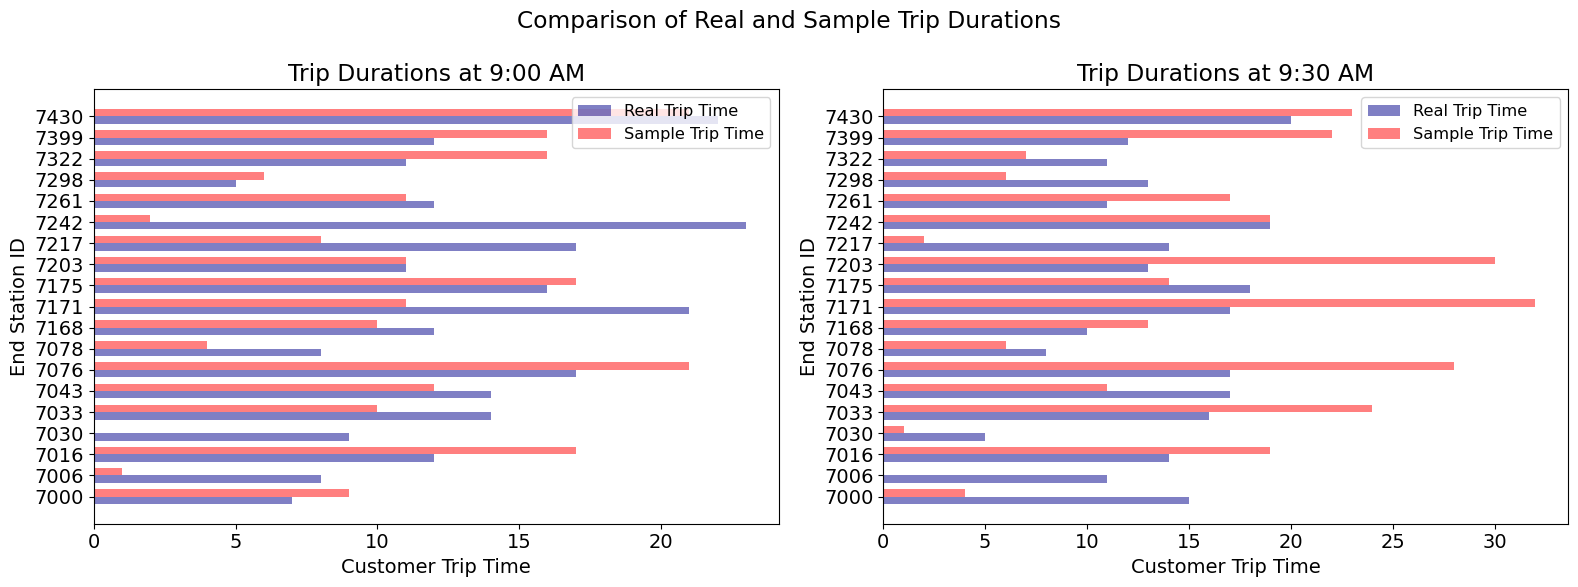

In [1781]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot for T=16
T = 20
real_Trip_Duration = subset_df[subset_df["End Time (per 30min)"] == T][["End Time (per 30min)", "End Station Id", "Trip_Duration"]].sort_values(by="End Time (per 30min)", ascending=False)
avg_trip_time = np.round(real_Trip_Duration.groupby("End Station Id")["Trip_Duration"].mean())

sample_trip = end_flow_df[end_flow_df["End Time"]== T]["End ID"].value_counts()
sample_trips = pd.DataFrame({"End Station Id": sample_trip.index, "Sample Trip Times": sample_trip.values})

comparison_df = pd.merge(avg_trip_time, sample_trips,
                         on="End Station Id", how="outer")
comparison_df.columns = ["End Station Id","Real Trip Times", "Sample Trip Times"]
comparison_df = comparison_df.sort_values(by="End Station Id")

bar_width = 0.35
ax[0].barh(np.arange(len(comparison_df)), comparison_df["Real Trip Times"],
           color="darkblue", alpha=0.5, height=bar_width, label="Real Trip Time")
ax[0].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample Trip Times"],
           color="red", alpha=0.5, height=bar_width, label="Sample Trip Time")
ax[0].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
ax[0].set_yticklabels(comparison_df["End Station Id"])
ax[0].set_ylabel("End Station ID")
ax[0].set_xlabel("Customer Trip Time")
ax[0].set_title("Trip Durations at 9:00 AM")
ax[0].legend(loc='upper right', fontsize='small')

# Plot for T=17
T = 21
real_Trip_Duration = subset_df[subset_df["End Time (per 30min)"] == T][["End Time (per 30min)", "End Station Id", "Trip_Duration"]].sort_values(by="End Time (per 30min)", ascending=False)
avg_trip_time = np.round(real_Trip_Duration.groupby("End Station Id")["Trip_Duration"].mean())


sample_trip = end_flow_df[end_flow_df["End Time"]
                          == T]["End ID"].value_counts()
sample_trips = pd.DataFrame(
    {"End Station Id": sample_trip.index, "Sample Trip Times": sample_trip.values})

comparison_df = pd.merge(avg_trip_time, sample_trips,
                         on="End Station Id", how="outer")
comparison_df.columns = ["End Station Id",
                         "Real Trip Times", "Sample Trip Times"]
comparison_df = comparison_df.sort_values(by="End Station Id")

ax[1].barh(np.arange(len(comparison_df)), comparison_df["Real Trip Times"],color="darkblue", alpha=0.5, height=bar_width, label="Real Trip Time")
ax[1].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample Trip Times"], color="red", alpha=0.5, height=bar_width, label="Sample Trip Time")
ax[1].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
ax[1].set_yticklabels(comparison_df["End Station Id"])
ax[1].set_ylabel("End Station ID")
ax[1].set_xlabel("Customer Trip Time")
ax[1].set_title("Trip Durations at 9:30 AM")
ax[1].legend(loc='upper right', fontsize='small')
fig.suptitle("Comparison of Real and Sample Trip Durations")
fig.tight_layout()
plt.show()


## Arrival Rate Verfication

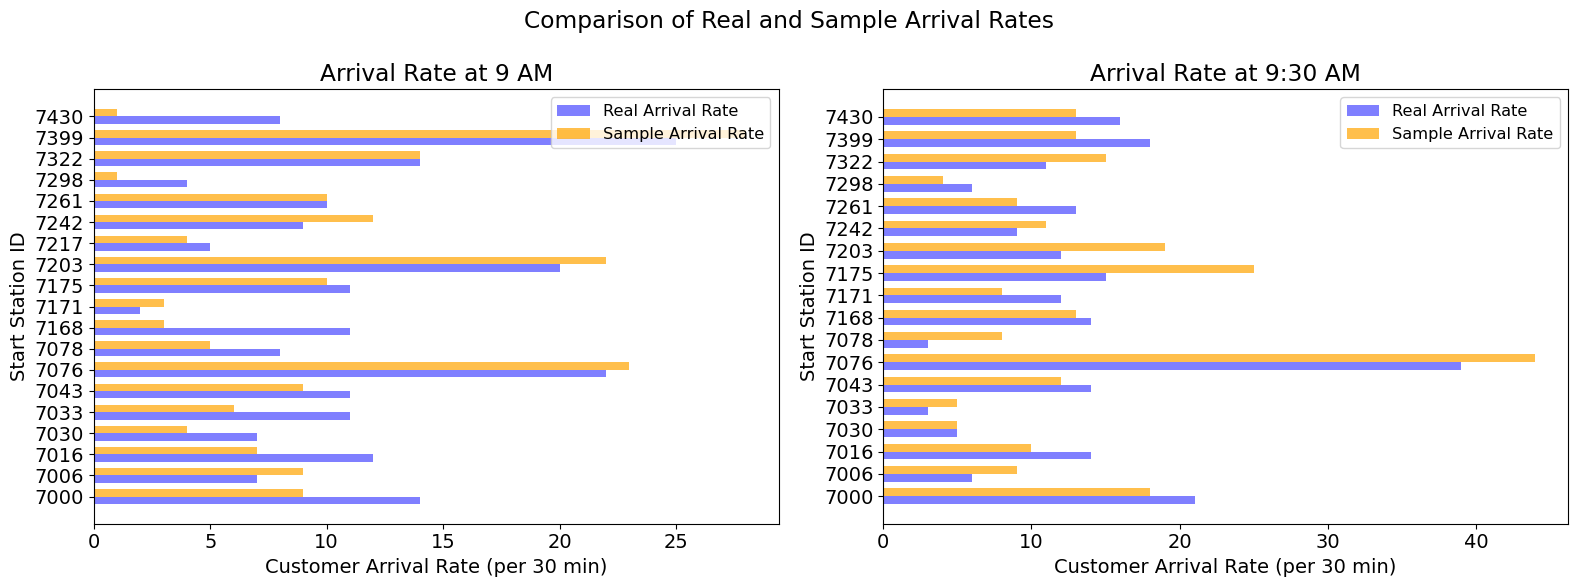

In [1782]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# First subplot for T=16
T = 18
real_8am_S_ID = arrival_df[arrival_df["Start Time (per 30min)"] == T][["Start Station Id", "ArrivalRate (per 30min)"]].sort_values(by="ArrivalRate (per 30min)", ascending=False)
sample_8am_s_ID = start_flow_df[start_flow_df["Start Time"]== T]["Start ID"].value_counts()
sample_8am_s_ID_df = pd.DataFrame({"Start Station Id": sample_8am_s_ID.index, "ArrivalRate (per 30min)": sample_8am_s_ID.values})

comparison_df = pd.merge(real_8am_S_ID, sample_8am_s_ID_df, on="Start Station Id", how="outer")
comparison_df.columns = ["Start Station Id", "Real ArrivalRate (per 30min)", "Sample ArrivalRate (per 30min)"]
comparison_df = comparison_df.sort_values(by="Start Station Id")

bar_width = 0.35
axs[0].barh(np.arange(len(comparison_df)), comparison_df["Real ArrivalRate (per 30min)"],color="blue", alpha=0.5, height=bar_width, label="Real Arrival Rate")
axs[0].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample ArrivalRate (per 30min)"],color="orange", alpha=0.7, height=bar_width, label="Sample Arrival Rate")
axs[0].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
axs[0].set_yticklabels(comparison_df["Start Station Id"])
axs[0].set_ylabel("Start Station ID")
axs[0].set_xlabel("Customer Arrival Rate (per 30 min)")
axs[0].set_title("Arrival Rate at 9 AM")
axs[0].legend(loc='upper right', fontsize='small')

# Second subplot for T=17
T = 19
real_8am_S_ID = arrival_df[arrival_df["Start Time (per 30min)"] == T][["Start Station Id", "ArrivalRate (per 30min)"]].sort_values(by="ArrivalRate (per 30min)", ascending=False)
sample_8am_s_ID = start_flow_df[start_flow_df["Start Time"]== T]["Start ID"].value_counts()
sample_8am_s_ID_df = pd.DataFrame({"Start Station Id": sample_8am_s_ID.index, "ArrivalRate (per 30min)": sample_8am_s_ID.values})

comparison_df = pd.merge(real_8am_S_ID, sample_8am_s_ID_df,on="Start Station Id", how="outer")
comparison_df.columns = ["Start Station Id", "Real ArrivalRate (per 30min)", "Sample ArrivalRate (per 30min)"]
comparison_df = comparison_df.sort_values(by="Start Station Id")

bar_width = 0.35
axs[1].barh(np.arange(len(comparison_df)), comparison_df["Real ArrivalRate (per 30min)"],color="blue", alpha=0.5, height=bar_width, label="Real Arrival Rate")
axs[1].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample ArrivalRate (per 30min)"],color="orange", alpha=0.7, height=bar_width, label="Sample Arrival Rate")
axs[1].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
axs[1].set_yticklabels(comparison_df["Start Station Id"])
axs[1].set_ylabel("Start Station ID")
axs[1].set_xlabel("Customer Arrival Rate (per 30 min)")
axs[1].set_title("Arrival Rate at 9:30 AM")
axs[1].legend(loc='upper right', fontsize='small')

fig.suptitle("Comparison of Real and Sample Arrival Rates")
fig.tight_layout()
plt.show()


# Starting Solutions

## Equal Allocation

In [1783]:
unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
Stations = {}
level_sum = 0
level_sum = 0
capacity_sum = 0


for i, station in enumerate(unique_stations):
    x_i = 399//19
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum += x_i
    for station_id, station in Stations.items():
        capacity_sum += station.capacity


StationDict = {station.id: station for station in Stations.values()}

# Print the initial bike list for each station
val_level_sum = []
val_capacity_sum = []
count = 0
for station_id, station in Stations.items():
    count += 1
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
    val_level_sum.append(station.level)
    val_capacity_sum.append(station.capacity)
print(count)

print("Level Sum", sum(val_level_sum))
print("Capacity Sum", sum(val_capacity_sum))


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

## Flow Rate Model Solution

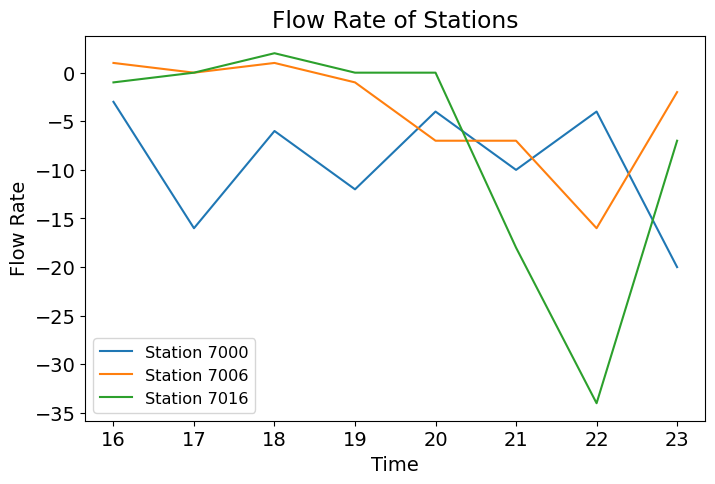

In [1786]:
plt.figure(figsize=(8, 5))
unique_stations = np.unique(subset_df["Start Station Id"].values)

for station_ids in unique_stations[:3]:
    start_flow = start_flow_count.loc[station_ids]
    end_flow = end_flow_count.loc[station_ids]
    flow_rate = end_flow - start_flow 
    plt.plot(flow_rate.index, flow_rate.values, label=f'Station {station_ids}')

plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.title('Flow Rate of Stations')
plt.legend(loc='lower left', fontsize='small')
plt.show()


In [ ]:
Calendar = SimClasses.EventCalendar()
ZSimRNG = SimRNG_Modified.InitializeRNSeed()
 Stations = {}
  total_bikes_assigned = 0

   for i, (station_id, station) in enumerate(StationDict.items()):
        x_i = station.level
        r_i = station.capacity
        # Check if it's the last station, and assign the remaining capacity
        if i == len(StationDict) - 1:
            x_i = total_bikes - total_bikes_assigned
        Stations[station_id] = Station(
            station_id=station_id, level=x_i, capacity=r_i)
        total_bikes_assigned += x_i

    # Find the stations with the highest and lowest flow rates

    for _ in range(remaining_bikes):
    idx = np.random.randint(num_stations)
    if station_levels[idx] < station_capacities[idx]:
        station_levels[idx] += 1

    for _ in range(remaining_capacity):
        idx = np.random.randint(num_stations)
        station_capacities[idx] += 1

    # station_id1 = flow_rate.sum(axis=1).idxmax()
    # station_id2 = flow_rate.sum(axis=1).idxmin()

    for station_id, station in Stations.items():
        print(
            f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

    # Move w bikes between the two stations
    Stations[station_id1].level -= w
    Stations[station_id2].level += w

    # Check if the new bike list is valid (no negative bike levels)
    if Stations[station_id1].level < 0:
        continue

    # Update the StationDict with the new bike list
    StationDict = {station.id: station for station in Stations.values()}

    # Run your simulation with the updated StationDict and calculate the new total error
    new_total_error = run_simulation(StationDict, T, Calendar)

    # If the new total error is lower than the best total error, update the best bike list
    if new_total_error < best_total_error:
        best_total_error = new_total_error
        best_bike_list = {station.id: station.Get_Bike_List()
                          for station in Stations.values()}


In [1800]:
# Parameters
num_stations = 20
total_capacity = 500
total_bikes = 399
min_station_capacity = 12
max_station_capacity = 32

# Assuming start_flow_df and end_flow_df are available
start_time = 16
end_time = 25

# Calculate flow rate using pandas pivot tables
start_flow_count = start_flow_df.pivot_table(
    index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, start_time:end_time]
end_flow_count = end_flow_df.pivot_table(
    index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, start_time:end_time]
flow_rate = end_flow_count - start_flow_count

# Calculate flow rate data as a dictionary
flow_rate_data = flow_rate.sum(axis=1).to_dict()

# Calculate capacities and levels based on flow rates
station_ids = list(flow_rate_data.keys())
flow_rates = np.array(list(flow_rate_data.values()))

# Initialize station capacities
station_capacities = np.clip(flow_rates + total_capacity //
                             num_stations, min_station_capacity, max_station_capacity)

# Initialize station levels based on flow rates
station_levels = np.zeros(num_stations, dtype=int)
for i, station_id in enumerate(station_ids):
    if station_id in flow_rate_data:
        flow_rate = flow_rate_data[station_id]
        if np.isnan(flow_rate):
            level = 0
        else:
            level = (np.round(flow_rate * total_bikes / np.sum(flow_rate)))
            if np.isnan(level):
                level = 0
            level = np.clip(level, 0, total_capacity)
        station_levels[i] = level
    else:
        station_levels[i] = np.clip(
            total_capacity // num_stations, min_station_capacity, max_station_capacity)

# Adjust capacities and levels to meet the constraints
remaining_bikes = total_bikes - np.sum(station_levels)
remaining_capacity = total_capacity - np.sum(station_capacities)

while remaining_bikes > 0 or remaining_capacity > 0:
    for i in range(num_stations):
        if remaining_bikes > 0:
            increment = min(remaining_bikes,
                            station_capacities[i]-station_levels[i])
            station_levels[i] += increment
            remaining_bikes -= increment
        if remaining_capacity > 0:
            increment = min(remaining_capacity,
                            max_station_capacity-station_capacities[i])
            station_capacities[i] += increment
            remaining_capacity -= increment
        if remaining_bikes <= 0 and remaining_capacity <= 0:
            break

# Create station instances and store in a dictionary
stations = {}
for station_id, capacity, level in zip(station_ids, station_capacities, station_levels):
    stations[station_id] = Station(
        station_id=station_id, level=level, capacity=capacity)

# Print the initial bike list for each station
for station_id, station in stations.items():
    print(
        f"Station {station_id} Initial Bike List: {station.level} / {station.capacity}")

# Print the sum of levels and capacities for all stations
print("Level Sum:", sum(station.level for station in stations.values()))
print("Capacity Sum:", sum(station.capacity for station in stations.values()))


Station 7000 Initial Bike List: 399 / 32
Station 7006 Initial Bike List: 399 / 32
Station 7016 Initial Bike List: 399 / 32
Station 7030 Initial Bike List: 399 / 32
Station 7033 Initial Bike List: 0 / 32
Station 7043 Initial Bike List: 0 / 32
Station 7076 Initial Bike List: 399 / 32
Station 7078 Initial Bike List: 399 / 32
Station 7168 Initial Bike List: 399 / 32
Station 7171 Initial Bike List: 399 / 32
Station 7175 Initial Bike List: 399 / 21
Station 7203 Initial Bike List: 0 / 25
Station 7217 Initial Bike List: 399 / 24
Station 7242 Initial Bike List: 399 / 12
Station 7261 Initial Bike List: 399 / 17
Station 7298 Initial Bike List: 0 / 25
Station 7322 Initial Bike List: 399 / 12
Station 7399 Initial Bike List: 399 / 12
Station 7430 Initial Bike List: 399 / 32
Level Sum: 5985
Capacity Sum: 500


In [1515]:


# Parameters
num_stations = 20
total_capacity = 500
total_bikes = 399
min_station_capacity = 12
max_station_capacity = 32

# Assuming start_flow_df and end_flow_df are available
start_time = 8
end_time = 12

# Calculate flow rate using pandas pivot tables
start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, start_time:end_time]
end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, start_time:end_time]
flow_rate = end_flow_count - start_flow_count

# Calculate flow rate data as a dictionary
flow_rate_data = flow_rate.sum(axis=1).to_dict()

# Calculate capacities and levels based on flow rates
station_ids = list(flow_rate_data.keys())
flow_rates = np.array(list(flow_rate_data.values()))

# Normalize flow rates to sum up to the total number of bikes
normalized_flow_rates = np.round(
    flow_rates * total_bikes / np.sum(flow_rates)).astype(int)

# Initialize station capacities and levels
station_capacities = np.clip(normalized_flow_rates + total_capacity //
                             num_stations, min_station_capacity, max_station_capacity)
station_levels = np.clip(normalized_flow_rates, 0, station_capacities)

# Adjust capacities and levels to meet the constraints
remaining_bikes = total_bikes - np.sum(station_levels)
remaining_capacity = total_capacity - np.sum(station_capacities)

for _ in range(remaining_bikes):
    idx = np.random.randint(num_stations-1)
    if station_levels[idx] < station_capacities[idx]:
        station_levels[idx] += 1

for _ in range(remaining_capacity):
    idx = np.random.randint(num_stations-1)
    station_capacities[idx] += 1

# Create station instances and store in a dictionary
stations = {}
for station_id, capacity, level in zip(station_ids, station_capacities, station_levels):
    stations[station_id] = Station(station_id=station_id, level=level, capacity=capacity)

# Print the initial bike list for each station
for station_id, station in stations.items():
    print(f"Station {station_id} Initial Bike List: {station.level} / {station.capacity}")

# Print the sum of levels and capacities for all stations
print("Level Sum:", sum(station.level for station in stations.values()))
print("Capacity Sum:", sum(station.capacity for station in stations.values()))


Station 7000 Initial Bike List: 12 / 27
Station 7006 Initial Bike List: 12 / 28
Station 7016 Initial Bike List: 12 / 25
Station 7030 Initial Bike List: 12 / 30
Station 7033 Initial Bike List: 12 / 23
Station 7043 Initial Bike List: 12 / 23
Station 7076 Initial Bike List: 12 / 23
Station 7078 Initial Bike List: 12 / 26
Station 7168 Initial Bike List: 12 / 26
Station 7171 Initial Bike List: 12 / 24
Station 7175 Initial Bike List: 12 / 32
Station 7203 Initial Bike List: 12 / 18
Station 7217 Initial Bike List: 12 / 25
Station 7242 Initial Bike List: 12 / 31
Station 7261 Initial Bike List: 12 / 31
Station 7298 Initial Bike List: 12 / 28
Station 7322 Initial Bike List: 12 / 26
Station 7399 Initial Bike List: 12 / 30
Station 7430 Initial Bike List: 12 / 24
Level Sum: 228
Capacity Sum: 500


In [1499]:
unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
Stations = {}
level_sum = []
capacity_sum = []

# Calculate the number of bikes to allocate to each station
bikes_per_station = total_bikes // num_stations

# Allocate bikes and initialize the stations
capacity_per_station = total_capacity // num_stations
for i, station in enumerate(unique_stations):
    x_i = bikes_per_station // 2
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum.append(x_i)
    capacity_sum.append(r_i)

StationDict = {station.id: station for station in Stations.values()}

# Assign any remaining bikes to the stations with the most available capacity
remaining_bikes = total_bikes - sum(level_sum)
while remaining_bikes > 0:
    # Find the station with the most available capacity
    max_capacity = -1
    max_station = None
    for station_id, station in Stations.items():
        available_capacity = station.capacity - station.level
        if available_capacity > max_capacity:
            max_capacity = available_capacity
            max_station = station
    # Assign one bike to the station and update the remaining number of bikes
    max_station.level += 1
    remaining_bikes -= 1
    level_sum[unique_stations.tolist().index(max_station.id)] += 1

# Print the initial bike list for each station
level_sum = []
capacity_sum = []
for station_id, station in Stations.items():
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
    level_sum.append(station.level)
    capacity_sum.append(station.capacity)

print("Level Sum", sum(level_sum))
print("Capacity Sum", sum(capacity_sum))


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10']
Station 7033 Initial Bike List: ['7033-1', '7033-2', '7033-3', '7033-4', '7033-5', '7033-6', '7033-7', '7033-8', '7033-9', '7033-10']
Station 7043 Initial Bike List: ['7043-1', '7043-2', '7043-3', '7043-4', '7043-5', '7043-6', '7043-7', '7043-8', '7043-9', '7043-10']
Station 7076 Initial Bike List: ['7076-1', '7076-2', '7076-3', '7076-4', '7076-5', '7076-6', '7076-7', '7076-8', '7076-9', '7076-10']
Station 7078 Initial Bike List: ['7078-1', '7078-2', '7078-3',

In [1801]:
# Define the time frame
start_time = 16
end_time = 24

# Calculate the number of stations and bikes per station based on capacity constraints
unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
avg_capacity = total_capacity // num_stations
avg_bikes = total_bikes // num_stations

# Calculate the start and end flow counts for each station
start_flow_count = start_flow_df.pivot_table(
    index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, start_time:end_time]
end_flow_count = end_flow_df.pivot_table(
    index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, start_time:end_time]

# Initialize the stations and create a dictionary mapping station IDs to Station instances
Stations = {}
station_capacities = []
station_levels = []
for station_id in unique_stations:
    # Calculate the maximum and minimum number of bikes and docks based on flow rates
    start_flow = start_flow_count.loc[station_id].values
    end_flow = end_flow_count.loc[station_id].values
    net_flow = sum(end_flow) - sum(start_flow)
    min_bikes = avg_bikes - max(min(start_flow), -net_flow, 0)
    max_bikes = avg_bikes + max(max(end_flow), -net_flow, 0)
    # ensure max bikes does not exceed station capacity limit
    max_bikes = min(max_bikes, 32)
    max_docks = avg_capacity - max(end_flow)
    # ensure sum of max_bikes and max_docks does not exceed total capacity
    max_docks = min(max_docks, total_capacity - max_bikes)

    # Set the initial level and capacity of the station based on the calculated minimum and maximum values
    level = min(max(min_bikes, net_flow +max(0, sum(start_flow) - sum(end_flow))), max_bikes)
    capacity = max_bikes + max_docks
    
    Stations[station_id] = Station(
        station_id=station_id, level=level, capacity=capacity)
    station_capacities.append(capacity)
    station_levels.append(level)

# Normalize station capacities and levels to ensure that the total capacity and number of bikes are exactly equal to the target values
total_station_capacity = sum(station_capacities)
#capacity_per_station = total_capacity 
station_capacity_factors = [total_capacity /
                            total_station_capacity] * num_stations
for i, station_id in enumerate(unique_stations):
    Stations[station_id].capacity = int(
        station_capacities[i] * station_capacity_factors[i])
    Stations[station_id].level = int(
        station_levels[i] * total_bikes / sum(station_levels))

# Print the initial bike list for each station
level_sum = []
capacity_sum = []
for station_id, station in Stations.items():
    #print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
    level_sum.append(station.level)
    capacity_sum.append(station.capacity)

print("Level Sum", sum(level_sum))
print("Capacity Sum", sum(capacity_sum))

# Allocate any remaining bikes to the stations with the most available capacity
# Assign any remaining bikes to the stations while considering the flow rate
remaining_bikes = total_bikes - sum(level_sum)
while remaining_bikes > 0:
    # Find the station with the most available capacity
    max_capacity = 32
    max_station = None
    for station_id, station in Stations.items():
        available_capacity = station.capacity - station.level
        if available_capacity > max_capacity:
            max_capacity = available_capacity
            max_station = station
    # Check the flow rate of the station
    start_flow = start_flow_count.loc[max_station.id].values
    end_flow = end_flow_count.loc[max_station.id].values
    net_flow = sum(end_flow) - sum(start_flow)
    # If there is positive net flow, remove a bike
    if net_flow > 0:
        max_station.level -= 1
        remaining_bikes -= 1
    # If there is negative net flow, add a bike
    elif net_flow < 0:
        if max_station.level < max_station.capacity:
            max_station.level += 1
            remaining_bikes -= 1
    # If there is no net flow, add or remove a bike based on the available capacity
    else:
        if max_station.level < max_station.capacity:
            max_station.level += 1
            remaining_bikes -= 1
        else:
            max_station.level -= 1
            remaining_bikes -= 1

# Create a new dictionary to store the updated station instances
# Create a new dictionary to store the updated station instances
updated_stations = {}
final_stations = {}
capacity_sum = 0
# Iterate over the original Stations dictionary
# Iterate over the original Stations dictionary
for i, (station_id, station) in enumerate(Stations.items()):
    # Update the station instance and store it in the new dictionary
    updated_station = Station(station_id=station_id,
                              level=station.level, capacity=station.capacity)
    updated_stations[station_id] = updated_station

    # Allocate capacity to the stations based on the average capacity and the remaining capacity
    r_i = avg_capacity
    if i == num_stations - 1:
        r_i = total_capacity - avg_capacity * (num_stations - 1)
    r_i = min(r_i, 32)  # enforce maximum capacity constraint
    updated_station.capacity = r_i

    print(f"Station {station_id} Initial Bike List: {updated_station.Get_Bike_List()}")
    capacity_sum += updated_station.capacity
    final_stations[station_id] = Station(
        station_id=station_id, level=updated_station.level, capacity=r_i)


# Replace the original Stations dictionary with the final one
Stations = final_stations

# Print the sum of levels and capacities for all stations
level_sum = [station.level for station in Stations.values()]
capacity_sum = [station.capacity for station in Stations.values()]
print("Level Sum:", sum(level_sum))
print("Capacity Sum:", sum(capacity_sum))
print("Total Capacity:", sum(capacity_sum))


Level Sum 394
Capacity Sum 491
Station 7000 Initial Bike List: ['7000-1', '7000-2']
Station 7006 Initial Bike List: []
Station 7016 Initial Bike List: []
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3']
Station 7033 Initial Bike List: ['7033-1', '7033-2', '7033-3', '7033-4', '7033-5', '7033-6', '7033-7', '7033-8', '7033-9', '7033-10', '7033-11', '7033-12', '7033-13', '7033-14', '7033-15', '7033-16', '7033-17', '7033-18', '7033-19', '7033-20', '7033-21', '7033-22', '7033-23', '7033-24', '7033-25', '7033-26', '7033-27', '7033-28', '7033-29', '7033-30', '7033-31', '7033-32', '7033-33', '7033-34', '7033-35', '7033-36', '7033-37', '7033-38']
Station 7043 Initial Bike List: ['7043-1', '7043-2', '7043-3', '7043-4', '7043-5', '7043-6', '7043-7', '7043-8', '7043-9', '7043-10', '7043-11', '7043-12', '7043-13', '7043-14', '7043-15', '7043-16', '7043-17', '7043-18', '7043-19', '7043-20', '7043-21', '7043-22', '7043-23', '7043-24', '7043-25', '7043-26', '7043-27', '7043-28', '7043-29'

In [1497]:
# Define the time frame
start_time = 16
end_time = 24

# Calculate the number of stations and bikes per station based on capacity constraints
unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
avg_capacity = total_capacity // num_stations
avg_bikes = total_bikes // num_stations

# Calculate the start and end flow counts for each station
start_flow_count = start_flow_df.pivot_table(
    index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, start_time:end_time]
end_flow_count = end_flow_df.pivot_table(
    index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, start_time:end_time]

# Initialize the stations and create a dictionary mapping station IDs to Station instances
Stations = {}
station_capacities = []
station_levels = []
for station_id in unique_stations:
    # Calculate the maximum and minimum number of bikes and docks based on flow rates
    start_flow = start_flow_count.loc[station_id].values
    end_flow = end_flow_count.loc[station_id].values
    net_flow = sum(end_flow) - sum(start_flow)
    min_bikes = avg_bikes - max(min(start_flow), -net_flow, 0)
    max_bikes = avg_bikes + max(max(end_flow), -net_flow, 0)
    # ensure max bikes does not exceed station capacity limit
    max_bikes = min(max_bikes, 32)
    max_docks = avg_capacity - max(end_flow)
    # ensure sum of max_bikes and max_docks does not exceed total capacity
    max_docks = min(max_docks, total_capacity - max_bikes)

    # Set the initial level and capacity of the station based on the calculated minimum and maximum values
    level = min(max(min_bikes, net_flow +
                max(0, sum(start_flow) - sum(end_flow))), max_bikes)
    capacity = max_bikes + max_docks
    capacity = min(capacity, 32)  # enforce maximum capacity constraint

    Stations[station_id] = Station(
        station_id=station_id, level=level, capacity=capacity)
    station_capacities.append(capacity)
    station_levels.append(level)

# Normalize station capacities and levels to ensure that the total capacity and number of bikes are exactly equal to the target values
total_station_capacity = sum(station_capacities)
#capacity_per_station = total_capacity
station_capacity_factors = [total_capacity /
                            total_station_capacity] * num_stations
for i, station_id in enumerate(unique_stations):
    Stations[station_id].capacity = int(
        station_capacities[i] * station_capacity_factors[i])
    Stations[station_id].level = int(
        station_levels[i] * total_bikes / sum(station_levels))

# Print the initial bike list for each station
level_sum = []
capacity_sum = []
for station_id, station in Stations.items():
    #print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
    level_sum.append(station.level)
    capacity_sum.append(station.capacity)

print("Level Sum", sum(level_sum))
print("Capacity Sum", sum(capacity_sum))

# Allocate any remaining bikes to the stations with the most available capacity
# Assign any remaining bikes to the stations while considering the flow rate
remaining_bikes = total_bikes - sum(level_sum)
while remaining_bikes > 0:
    # Find the station with the most available capacity
    max_capacity = -1
    max_station = None
    for station_id, station in Stations.items():
        available_capacity = station.capacity - station.level
        if available_capacity > max_capacity:
            max_capacity = available_capacity
            max_station = station
    # Check the flow rate of the station
    start_flow = start_flow_count.loc[max_station.id].values
    end_flow = end_flow_count.loc[max_station.id].values
    net_flow = sum(end_flow) - sum(start_flow)
    # If there is positive net flow, remove a bike
    if net_flow > 0:
        max_station.level -= 1
        remaining_bikes -= 1
    # If there is negative net flow, add a bike
    elif net_flow < 0:
        if max_station.level < max_station.capacity:
            max_station.level += 1
            remaining_bikes -= 1
    # If there is no net flow, add or remove a bike based on the available capacity
    else:
        if max_station.level < max_station.capacity:
            max_station.level += 1
            remaining_bikes -= 1
        else:
            max_station.level -= 1
            remaining_bikes -= 1

# Create a new dictionary to store the updated station instances
# Create a new dictionary to store the updated station instances
updated_stations = {}
final_stations = {}
capacity_sum = 0
# Iterate over the original Stations dictionary
# Iterate over the original Stations dictionary
for i, (station_id, station) in enumerate(Stations.items()):
    # Update the station instance and store it in the new dictionary
    updated_station = Station(station_id=station_id,
                              level=station.level, capacity=station.capacity)
    updated_stations[station_id] = updated_station

    # Allocate capacity to the stations based on the average capacity and the remaining capacity
    r_i = avg_capacity
    if i == num_stations - 1:
        r_i = total_capacity - avg_capacity * (num_stations - 1)
    r_i = min(r_i, 32)  # enforce maximum capacity constraint
    updated_station.capacity = r_i

    print(
        f"Station {station_id} Initial Bike List: {updated_station.Get_Bike_List()}")
    capacity_sum += updated_station.capacity
    final_stations[station_id] = Station(station_id=station_id, level=updated_station.level, capacity=r_i)


# Replace the original Stations dictionary with the final one
Stations = final_stations

# Print the sum of levels and capacities for all stations
level_sum = [station.level for station in Stations.values()]
capacity_sum = [station.capacity for station in Stations.values()]
print("Level Sum:", sum(level_sum))
print("Capacity Sum:", sum(capacity_sum))
print("Total Capacity:", sum(capacity_sum))


Level Sum 394
Capacity Sum 488
Station 7000 Initial Bike List: ['7000-1']
Station 7006 Initial Bike List: ['7006-1']
Station 7016 Initial Bike List: []
Station 7030 Initial Bike List: ['7030-1']
Station 7033 Initial Bike List: ['7033-1', '7033-2', '7033-3', '7033-4', '7033-5', '7033-6', '7033-7', '7033-8', '7033-9', '7033-10', '7033-11', '7033-12', '7033-13', '7033-14', '7033-15', '7033-16', '7033-17', '7033-18', '7033-19', '7033-20', '7033-21', '7033-22', '7033-23', '7033-24', '7033-25', '7033-26', '7033-27', '7033-28', '7033-29', '7033-30', '7033-31', '7033-32', '7033-33', '7033-34', '7033-35', '7033-36', '7033-37', '7033-38', '7033-39', '7033-40', '7033-41', '7033-42', '7033-43', '7033-44', '7033-45', '7033-46', '7033-47', '7033-48', '7033-49', '7033-50', '7033-51', '7033-52', '7033-53', '7033-54']
Station 7043 Initial Bike List: ['7043-1', '7043-2', '7043-3', '7043-4', '7043-5', '7043-6', '7043-7', '7043-8', '7043-9', '7043-10', '7043-11', '7043-12', '7043-13', '7043-14']
Station 7

# Optimizing Bike Allocations

- Time Frame: 8am - 12pm
- number of stations = 20
- station capcities: 12 <= r_i <= 32
- Bike per station: 0 <= x_i <= r_i
- total capacity of stations = 500
- total number of bikes = 399


In [ ]:
# def optimize_bikes(x, day_seed, m):
#     np.random.seed(day_seed)
#     stations = [station.id for station in Stations]
#     statE = [i for i, s in enumerate(Stations) if s.level() == 0]
#     statF = [i for i, s in enumerate(Stations) if s.level() == s.capacity()]

#     r = {station.id: station.Capacity() for station in Stations}
#     w = (sum(x.values()) / len(stations) - target_bikes_per_station) / 2
#     x_k_minus_1 = x.copy()
#     best_x = x.copy()
#     best_f = evaluate(x)

#     for k in range(1, m + 1):
#         x_trial = generate_trial_solution(x_k_minus_1, statE, statF, r, w)
#         if all(0 <= x_trial[s] <= r[s] for s in stations):
#             f_trial = evaluate(x_trial)
#             if f_trial < best_f:
#                 best_x = x_trial.copy()
#                 best_f = f_trial
#         else:
#             f_trial = float('inf')
#         x_k_minus_1 = best_x.copy()
#     return best_x


In [ ]:
# def optimize_bikes(x, day_seed, m):
#     np.random.seed(day_seed)
#     stations = [station.id for station in Stations]
#     statE = [i for i, s in enumerate(Stations) if s.level() == 0]
#     statF = [i for i, s in enumerate(Stations) if s.level() == s.capacity()]

#     r = {station.id: station.Capacity() for station in Stations}
#     w = (sum(x.values()) / len(stations) - target_bikes_per_station) / 2
#     x_k_minus_1 = x.copy()
#     best_x = x.copy()
#     best_f = evaluate(x)

#     for k in range(1, m + 1):
#         x_trial = generate_trial_solution(x_k_minus_1, statE, statF, r, w)
#         if all(0 <= x_trial[s] <= r[s] for s in stations):
#             f_trial = evaluate(x_trial)
#             if f_trial < best_f:
#                 best_x = x_trial.copy()
#                 best_f = f_trial
#         else:
#             f_trial = float('inf')
#         x_k_minus_1 = best_x.copy()
#     return best_x

import pandas as pd
import numpy as np
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()
np.random.seed(1)

Calendar = SimClasses.EventCalendar()
TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []
Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []

CI_total_error_list = []

for days in range(0, 1, 1):
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    inter_arrival_time_list = []
    arrival_time_list = []
    start_station_id_list = []
    end_station_id_list = []
    start_time_list = []
    end_time_list = []
    trip_time_list = []
############################################################################################################################################################################
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    total_capacity = 480
    total_bikes = 380
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0

    for i, station in enumerate(unique_stations):
        x_i = 20
        r_i = capacity_per_station
        if i == num_stations - 1:
            # Allocate the remaining capacity to the last station
            r_i = total_capacity - capacity_per_station * (num_stations - 1)
        Stations[station] = Station(
            station_id=station, level=x_i, capacity=r_i)
        level_sum += x_i
        for station_id, station in Stations.items():
            capacity_sum += station.capacity

    StationDict = {station.id: station for station in Stations.values()}

    # Print the initial bike list for each station
    val_level_sum = []
    val_capacity_sum = []
    count = 0
    for station_id, station in Stations.items():
        count += 1
        print(
            f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print(count)

    print("Level Sum", sum(val_level_sum))
    print("Capacity Sum", sum(val_capacity_sum))


############################################################################################################################################################################

    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 25):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        print()
        print("Interval:", T)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
##################################################################################################################################################

    objective_fun = Full_Error + Empty_Error
    CI_total_error_list.append(objective_fun)
    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)

    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    print()

    Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list[-1],
                              "Empty Error": CI_Empty_Error_list[-1],
                              "Total Error": CI_total_error_list[-1]})

    BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list[-1],
                               "End Station ID": CI_end_station_id_list[-1],
                               "Arrival Rate": CI_arrival_time_list[-1],
                               "Interarrival Rate": CI_inter_arrival_time_list[-1],
                               "Start Time": CI_start_time_list[-1],
                               "End Time": CI_end_time_list[-1],
                               "Trip Time": CI_trip_time_list[-1]})

    station_id = BikeSim_DF["Start Station ID"].values[0]
    end_station_id = BikeSim_DF["End Station ID"].values[0]
    start_times = BikeSim_DF["Start Time"].values[0]
    end_times = BikeSim_DF["End Time"].values[0]
    trip_times = BikeSim_DF["Trip Time"].values[0]
    Arrival_Rates = BikeSim_DF["Arrival Rate"].values[0]
    Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[0]

    start_flow_df = pd.DataFrame(
        {"Start ID": station_id, "Start Time": start_times})
    end_flow_df = pd.DataFrame(
        {"End ID": end_station_id, "End Time": end_times, "Trip Time": trip_times})
    arrival_flow_df = pd.DataFrame(
        {"Start ID": station_id, "Arrival Rates": Arrival_Rates})
    interarrival_flow_df = pd.DataFrame(
        {"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

    start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
    start_flow_count = start_flow_count.loc[:, 16:24]
    end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
    end_flow_count = end_flow_count.loc[:, 16:24]

##################################################################################################################################################
# OPTIMIZE

    flow_rate = end_flow_count - start_flow_count

#     # Initialize the stations and create a dictionary mapping station IDs to Station instances
#     num_stations = len(unique_stations)
#     total_capacity = 480
#     total_bikes = 380

#     w = 2  # number of bike that can be moved from one station to another

#     # Calculate the start and end flow counts for each station
#     start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
#     start_flow_count = start_flow_count.loc[:, start_time:end_time]
#     end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
#     end_flow_count = end_flow_count.loc[:, start_time:end_time]
#     flow_rate = end_flow_count - start_flow_count
#     # Initialize the stations and create a dictionary mapping station IDs to Station instances
#     unique_stations = np.unique(subset_df["Start Station Id"].values)
#     Stations = {}
#     for station_id in unique_stations:
#         # Calculate the maximum and minimum number of bikes and docks based on flow rates
#         start_flow = start_flow_count.loc[station_id].values
#         end_flow = end_flow_count.loc[station_id].values
#         min_bikes = avg_bikes - min(start_flow)
#         max_bikes = avg_bikes + max(end_flow)
#         min_docks = avg_capacity - max(end_flow)
#         max_docks = avg_capacity - min(start_flow)

#         # Set the initial level and capacity of the station based on the calculated minimum and maximum values
#         level = min_bikes
#         capacity = max_bikes + max_docks
#         Stations[station_id] = Station(station_id=station_id, level=level, capacity=capacity)

# # Print the initial bike list for each station
# for station_id, station in Stations.items():
#     print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")


# Add your existing code to set up the simulation (before the optimization part)

# Parameters
num_iterations = 1000
w = 2

# Initialize the best error and best bike list
best_total_error = float('inf')
best_bike_list = {}

for _ in range(num_iterations):
    # Copy the current bike list as the starting point for this iteration
    new_bike_list = {station_id: station.level for station_id,
                     station in Stations.items()}

    # Find the stations with the highest and lowest flow rates
    station_id1 = flow_rate.sum(axis=1).idxmax()
    station_id2 = flow_rate.sum(axis=1).idxmin()

    # Move w bikes between the two stations
    new_bike_list[station_id1] -= w
    new_bike_list[station_id2] += w

    # Check if the new bike list is valid (no negative bike levels)
    if new_bike_list[station_id1] < 0:
        continue

    # Update the station levels with the new bike list
    for station_id, level in new_bike_list.items():
        Stations[station_id].level = level

    # Run your simulation with the updated bike list and calculate the new total error
    new_total_error =  # Calculate total error based on your simulation

    # If the new total error is lower than the best total error, update the best bike list
    if new_total_error < best_total_error:
        best_total_error = new_total_error
        best_bike_list = new_bike_list.copy()

# Update the station levels with the best bike list
for station_id, level in best_bike_list.items():
    Stations[station_id].level = level

# Print the best initial bike list for each station
for station_id, station in Stations.items():
    print(
        f"Station {station_id} Best Initial Bike List: {station.Get_Bike_List()}")

# Run the rest of your code



# OPTIMZE

##################################################################################################################################################
Total_Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list,
                                "Empty Error": CI_Empty_Error_list,
                                "Total Error": CI_total_error_list})

Total_BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                                 "End Station ID": CI_end_station_id_list,
                                 "Arrival Rate": CI_arrival_time_list,
                                 "Interarrival Rate": CI_inter_arrival_time_list,
                                 "Start Time": CI_start_time_list,
                                 "End Time": CI_end_time_list,
                                 "Trip Time": CI_trip_time_list})


In [1733]:

# NextCustomerID.counter = 0

# ZSimRNG = SimRNG_Modified.InitializeRNSeed()
# np.random.seed(1)

# Calendar = SimClasses.EventCalendar()
# TheCTStats = []
# TheDTStats = []
# TheQueues = []
# TheResources = []
# Stations = []
# CustomerList = []
# CI_Full_Error_list = []
# CI_Empty_Error_list = []

# CI_inter_arrival_time_list = []
# CI_arrival_time_list = []
# CI_start_station_id_list = []
# CI_end_station_id_list = []
# CI_start_time_list = []
# CI_end_time_list = []
# CI_trip_time_list = []

# CI_total_error_list = []

# for days in range(0, 1, 1):
#     Full_Error = 0
#     Empty_Error = 0
#     inital_count = 0

#     inter_arrival_time_list = []
#     arrival_time_list = []
#     start_station_id_list = []
#     end_station_id_list = []
#     start_time_list = []
#     end_time_list = []
#     trip_time_list = []
# ############################################################################################################################################################################
#     unique_stations = np.unique(subset_df["Start Station Id"].values)
#     num_stations = len(unique_stations)
#     total_capacity = 480
#     total_bikes = 380
#     Stations = {}
#     level_sum = 0
#     level_sum = 0
#     capacity_sum = 0

#     for i, station in enumerate(unique_stations):
#         x_i = 20
#         r_i = capacity_per_station
#         if i == num_stations - 1:
#             # Allocate the remaining capacity to the last station
#             r_i = total_capacity - capacity_per_station * (num_stations - 1)
#         Stations[station] = Station(
#             station_id=station, level=x_i, capacity=r_i)
#         level_sum += x_i
#         for station_id, station in Stations.items():
#             capacity_sum += station.capacity

#     StationDict = {station.id: station for station in Stations.values()}

#     # Print the initial bike list for each station
#     val_level_sum = []
#     val_capacity_sum = []
#     count = 0
#     for station_id, station in Stations.items():
#         count += 1
#         print(
#             f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
#         val_level_sum.append(station.level)
#         val_capacity_sum.append(station.capacity)
#     print(count)

#     print("Level Sum", sum(val_level_sum))
#     print("Capacity Sum", sum(val_capacity_sum))


# ############################################################################################################################################################################

#     SimFunctions.SimFunctionsInit(
#         Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
#     SimFunctions.Schedule(Calendar, "Start", 0)

#     NextEvent = Calendar.Remove()
#     SimClasses.Clock = NextEvent.EventTime
#     if NextEvent.EventType == "Start":
#         Start()

# ############################################################################################################################################################################
# # SIMULATION RUN
#     for T in range(15, 25):  # T = hours intervals
#         inital_count += 1
#         hour = T // 2
#         minute = 00 if T % 2 == 0 else 30
#         unit = 'PM' if hour >= 12 else 'AM'
#         print()
#         print("Interval:", T)
#         mini = 0
#         SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

#         if inital_count == 2:
#             Full_Error = 0
#             Empty_Error = 0

#         while True:
#             #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
#             NextEvent = Calendar.Remove()
#             SimClasses.Clock = NextEvent.EventTime
#             minute = int((SimClasses.Clock) % 60)
#             if SimClasses.Clock >= (T+1) * 30:
#                 break
#             if NextEvent.EventType == "inital_Customer_Arrival":
#                 Empty_Error = inital_Customer_Arrival(
#                     Empty_Error, CustomerList, T, minute)
#             elif NextEvent.EventType == "Customer_Arrival":
#                 Empty_Error = Customer_Arrival(
#                     Empty_Error, CustomerList, T, minute)
#             elif NextEvent.EventType == "Bike_Arrival":
#                 Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
# ##################################################################################################################################################

#     objective_fun = Full_Error + Empty_Error
#     CI_total_error_list.append(objective_fun)
#     CI_Full_Error_list.append(Full_Error)
#     CI_Empty_Error_list.append(Empty_Error)

#     CI_inter_arrival_time_list.append(inter_arrival_time_list)
#     CI_arrival_time_list.append(arrival_time_list)
#     CI_start_station_id_list.append(start_station_id_list)
#     CI_end_station_id_list.append(end_station_id_list)
#     CI_start_time_list.append(start_time_list)
#     CI_end_time_list.append(end_time_list)
#     CI_trip_time_list.append(trip_time_list)

#     print(f"End of Day {days}")
#     print("--------------------------------------------------------------------------------------------------------------------------------------------------")
#     print()

#     Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list[-1],
#                               "Empty Error": CI_Empty_Error_list[-1],
#                               "Total Error": CI_total_error_list[-1]})

#     BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list[-1],
#                                "End Station ID": CI_end_station_id_list[-1],
#                                "Arrival Rate": CI_arrival_time_list[-1],
#                                "Interarrival Rate": CI_inter_arrival_time_list[-1],
#                                "Start Time": CI_start_time_list[-1],
#                                "End Time": CI_end_time_list[-1],
#                                "Trip Time": CI_trip_time_list[-1]})

#     station_id = BikeSim_DF["Start Station ID"].values[0]
#     end_station_id = BikeSim_DF["End Station ID"].values[0]
#     start_times = BikeSim_DF["Start Time"].values[0]
#     end_times = BikeSim_DF["End Time"].values[0]
#     trip_times = BikeSim_DF["Trip Time"].values[0]
#     Arrival_Rates = BikeSim_DF["Arrival Rate"].values[0]
#     Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[0]

#     start_flow_df = pd.DataFrame(
#         {"Start ID": station_id, "Start Time": start_times})
#     end_flow_df = pd.DataFrame(
#         {"End ID": end_station_id, "End Time": end_times, "Trip Time": trip_times})
#     arrival_flow_df = pd.DataFrame(
#         {"Start ID": station_id, "Arrival Rates": Arrival_Rates})
#     interarrival_flow_df = pd.DataFrame(
#         {"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

#     start_flow_count = start_flow_df.pivot_table(
#         index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
#     start_flow_count = start_flow_count.loc[:, 16:24]
#     end_flow_count = end_flow_df.pivot_table(
#         index='End ID', columns='End Time', aggfunc='size', fill_value=0)
#     end_flow_count = end_flow_count.loc[:, 16:24]

# ##################################################################################################################################################
# # OPTIMIZE

#     flow_rate = end_flow_count - start_flow_count

#     # Parameters
#     num_iterations = 1000
#     w = 2

#     # Initialize the best error and best bike list
#     best_total_error = float('inf')
#     best_bike_list = {}

#     for _ in range(num_iterations):
#         # Copy the current bike list as the starting point for this iteration
#         new_bike_list = {station_id: station.level for station_id,
#                         station in Stations.items()}

#         # Find the stations with the highest and lowest flow rates
#         station_id1 = flow_rate.sum(axis=1).idxmax()
#         station_id2 = flow_rate.sum(axis=1).idxmin()

#         # Move w bikes between the two stations
#         new_bike_list[station_id1] -= w
#         new_bike_list[station_id2] += w

#         # Check if the new bike list is valid (no negative bike levels)
#         if new_bike_list[station_id1] < 0:
#             continue

#         # Update the station levels with the new bike list
#         for station_id, level in new_bike_list.items():
#             Stations[station_id].level = level

#         # Run your simulation with the updated bike list and calculate the new total error
#         new_total_error =  # Calculate total error based on your simulation

#         # If the new total error is lower than the best total error, update the best bike list
#         if new_total_error < best_total_error:
#             best_total_error = new_total_error
#             best_bike_list = new_bike_list.copy()

#     # Update the station levels with the best bike list
#     for station_id, level in best_bike_list.items():
#         Stations[station_id].level = level

#     # Print the best initial bike list for each station
#     for station_id, station in Stations.items():
#         print(
#             f"Station {station_id} Best Initial Bike List: {station.Get_Bike_List()}")

#     # Run the rest of your code


# # OPTIMZE

# ##################################################################################################################################################
# Total_Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list,
#                                 "Empty Error": CI_Empty_Error_list,
#                                 "Total Error": CI_total_error_list})

# Total_BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
#                                  "End Station ID": CI_end_station_id_list,
#                                  "Arrival Rate": CI_arrival_time_list,
#                                  "Interarrival Rate": CI_inter_arrival_time_list,
#                                  "Start Time": CI_start_time_list,
#                                  "End Time": CI_end_time_list,
#                                  "Trip Time": CI_trip_time_list})


In [ ]:
i = 0
station_id = BikeSim_DF["Start Station ID"].values[i]
end_station_id = BikeSim_DF["End Station ID"].values[i]
start_times = BikeSim_DF["Start Time"].values[i]
end_times = BikeSim_DF["End Time"].values[i]
trip_times = BikeSim_DF["Trip Time"].values[i]
Arrival_Rates = BikeSim_DF["Arrival Rate"].values[i]
Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[i]

print("List Lengths")
print(f"Start ID: {len(station_id)} | End ID: {len(end_station_id)}")
print(f"Start Time {len(start_times)} | End Time {len(end_times)}")
print(f"Trip Time {len(trip_times)}")
print(f"Arrival Rate {len(Arrival_Rates)} | Interarrival Rate {len(Interarrival_Rates)}")

start_flow_df = pd.DataFrame({"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame({"End ID": end_station_id,"End Time": end_times, "Trip Time": trip_times})
arrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Arrival_Rates})
interarrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

List Lengths
Start ID: 3066 | End ID: 2200
Start Time 3066 | End Time 2200
Trip Time 2200
Arrival Rate 3066 | Interarrival Rate 3066


In [1575]:
start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:23] 
start_flow_count


Start Time,16,17,18,19,20,21,22,23
Start ID,,,,,,,,
7000,8,17,10,19,19,11,21,25
7006,3,6,8,11,16,6,19,9
7016,6,7,9,13,14,27,59,35
7030,12,9,9,6,10,10,3,26
7033,8,3,10,2,8,30,11,12
7043,8,11,12,16,11,14,25,18
7076,6,10,26,58,27,40,52,52
7078,2,5,9,7,3,10,9,11
7168,4,12,10,12,8,13,22,13


In [1576]:
end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:23] 
end_flow_count

End Time,16,17,18,19,20,21,22,23
End ID,,,,,,,,
7000,3,3,4,6,5,6,4,5
7006,3,6,10,10,11,2,5,3
7016,6,7,10,13,15,26,25,33
7030,1,5,5,5,3,3,2,0
7033,8,11,11,2,7,29,14,12
7043,6,10,9,6,8,21,19,20
7076,7,9,25,48,27,27,33,41
7078,1,3,2,4,3,7,7,9
7168,6,12,17,25,11,14,16,19


In [1577]:
flow_rate = end_flow_count - start_flow_count
flow_rate


End Time,16,17,18,19,20,21,22,23
End ID,,,,,,,,
7000,-5,-14,-6,-13,-14,-5,-17,-20
7006,0,0,2,-1,-5,-4,-14,-6
7016,0,0,1,0,1,-1,-34,-2
7030,-11,-4,-4,-1,-7,-7,-1,-26
7033,0,8,1,0,-1,-1,3,0
7043,-2,-1,-3,-10,-3,7,-6,2
7076,1,-1,-1,-10,0,-13,-19,-11
7078,-1,-2,-7,-3,0,-3,-2,-2
7168,2,0,7,13,3,1,-6,6


# Results

In [1616]:
# unique_stations = np.unique(subset_df["Start Station Id"].values)
# StationDict = {station.id: station for station in Stations.values()}

# for i, station in enumerate(unique_stations):
#     x_i = total_bikes // 19
#     r_i = capacity_per_station
#     if i == num_stations - 1:
#     # Allocate the remaining capacity to the last station
#         r_i = total_capacity - capacity_per_station * (num_stations - 1)
#     Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
#     level_sum += x_i
#     for station_id, station in Stations.items():
#         capacity_sum += station.capacity

# # Print the initial bike list for each station
# val_level_sum = []
# val_capacity_sum = []
# count = 0
# for station_id, station in Stations.items():
#     count += 1
#     print(
#         f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
#     val_level_sum.append(station.level)
#     val_capacity_sum.append(station.capacity)
# print(count)
# print("Level Sum", sum(val_level_sum))
# print("Capacity Sum", sum(val_capacity_sum))


In [1821]:

SimClasses.Clock = 0
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []
Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []

total_error_list = []
CI_total_error_list = []

for days in range(0, 1, 1):
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    inter_arrival_time_list = []
    arrival_time_list = []
    start_station_id_list = []
    end_station_id_list = []
    start_time_list = []
    end_time_list = []
    trip_time_list = []
############################################################################################################################################################################
    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0

    for i, station in enumerate(unique_stations):
        x_i = total_bikes // 19
        r_i = capacity_per_station
        if i == num_stations - 1:
            # Allocate the remaining capacity to the last station
            r_i = total_capacity - capacity_per_station * (num_stations - 1)
        Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
        level_sum += x_i
        for station_id, station in Stations.items():
            capacity_sum += station.capacity

    StationDict = {station.id: station for station in Stations.values()}

    # Print the initial bike list for each station
    val_level_sum = []
    val_capacity_sum = []
    count = 0
    for station_id, station in Stations.items():
        count += 1
        print(
            f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print("Number of Stations", count)
    print("Level Sum", sum(val_level_sum))
    print("Capacity Sum", sum(val_capacity_sum))

############################################################################################################################################################################

    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 25):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        print()
        print("Interval:", T)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
                
        if T == 24:
            while Calendar.N() > 0:
                NextEvent = Calendar.Remove()
                SimClasses.Clock = NextEvent.EventTime
                minute = int((SimClasses.Clock) % 60)
                if NextEvent.EventType == "Bike_Arrival":
                    Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
##################################################################################################################################################
# OPTIMIZE
    objective_fun = Full_Error + Empty_Error
    total_error_list.append(objective_fun)

# OPTIMZE

    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)
    CI_total_error_list.append(total_error_list)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)

    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    print("ERROR", objective_fun)

Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list,
                        "Empty Error": CI_Empty_Error_list,
                        "Total Error": CI_total_error_list})

BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                        "End Station ID": CI_end_station_id_list,
                        "Arrival Rate": CI_arrival_time_list,
                        "Interarrival Rate": CI_inter_arrival_time_list,
                        "Start Time": CI_start_time_list,
                        "End Time": CI_end_time_list,
                        "Trip Time": CI_trip_time_list})

station_id = BikeSim_DF["Start Station ID"].values[0]
end_station_id = BikeSim_DF["End Station ID"].values[0]
start_times = BikeSim_DF["Start Time"].values[0]
end_times = BikeSim_DF["End Time"].values[0]
trip_times = BikeSim_DF["Trip Time"].values[0]
Arrival_Rates = BikeSim_DF["Arrival Rate"].values[0]
Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[0]

start_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame(
    {"End ID": end_station_id, "End Time": end_times, "Trip Time": trip_times})
arrival_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Arrival Rates": Arrival_Rates})
interarrival_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

start_flow_count = start_flow_df.pivot_table(
    index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:24]
end_flow_count = end_flow_df.pivot_table(
    index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:24]
flow_rate = end_flow_count - start_flow_count


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

In [1822]:
# Print the initial bike list for each station
val_level_sum = []
val_capacity_sum = []
count = 0
for station_id, station in Stations.items():
    count += 1
    print(
        f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
    val_level_sum.append(station.level)
    val_capacity_sum.append(station.capacity)
print("Number of Stations", count)
print("Level Sum", sum(val_level_sum))
print("Capacity Sum", sum(val_capacity_sum))


Station 7000 Initial Bike List: ['7168-13', '7399-17', '7006-18', '7399-4', '7217-4', '7016-18', '7016-21']
Station 7006 Initial Bike List: ['7203-21', '7217-18', '7076-19', '7261-15']
Station 7016 Initial Bike List: ['7168-20', '7175-6', '7043-16', '7430-17', '7078-6', '7217-11', '7175-2', '7322-9', '7217-17', '7076-1', '7171-19', '7000-20', '7168-18', '7242-17', '7399-21', '7242-12']
Station 7030 Initial Bike List: ['7171-17', '7430-5']
Station 7033 Initial Bike List: ['7006-17', '7016-8', '7016-17', '7203-2', '7030-15', '7171-2', '7000-21', '7430-11', '7016-20', '7000-6', '7171-5', '7006-11', '7242-2', '7399-6', '7000-14', '7000-8', '7203-6', '7030-6', '7030-7', '7030-11', '7430-13', '7030-18', '7016-3', '7030-12', '7322-11', '7076-7']
Station 7043 Initial Bike List: ['7430-14', '7430-3', '7000-11', '7006-5', '7076-3', '7006-19', '7175-19']
Station 7076 Initial Bike List: ['7175-7', '7399-7', '7076-4', '7399-11', '7033-7', '7171-14', '7175-14', '7171-15', '7078-13', '7016-1', '7076-

In [1823]:
end_flow_count - start_flow_count

End Time,16,17,18,19,20,21,22,23,24
End ID,,,,,,,,,
7000,-3,-18,1,-13,-5,7,-12,-20,-8
7006,1,0,1,0,0,0,-18,2,-25
7016,0,0,1,1,-3,-6,-16,-2,3
7030,-6,-5,-4,4,-6,-10,-4,-18,-4
7033,-1,7,2,1,0,0,1,0,0
7043,15,0,-4,-18,-9,5,7,-2,-9
7076,1,0,-1,-5,3,-1,-15,-4,10
7078,0,-10,-4,0,3,-4,6,-1,5
7168,-2,0,13,8,3,1,0,0,0


In [1730]:
# class BikeSharingSimulation:
#     def __init__(self):#, clock, Calendar):
#         #self.clock = clock
#         #self.Station = Station
#         #self.Calendar = None
#         self.EventTime = None
        
#         self.Stations = {}
#         self.CustomerList = []
#         self.TheCTStats = []
#         self.TheDTStats = []
#         self.TheQueues = []
#         self.TheResources = []
#         self.CI_Full_Error_list = []
#         self.CI_Empty_Error_list = []
#         self.CI_inter_arrival_time_list = []
#         self.CI_arrival_time_list = []
#         self.CI_start_station_id_list = []
#         self.CI_end_station_id_list = []
#         self.CI_start_time_list = []
#         self.CI_end_time_list = []
#         self.CI_trip_time_list = []
#         self.total_error_list = []
#         self.CI_total_error_list = []
        

#     def initialize_stations(self, total_bikes=399, total_capacity=500):
#         unique_stations = np.unique(subset_df["Start Station Id"].values)
#         num_stations = len(unique_stations)
#         capacity_per_station = total_capacity // num_stations

#         level_sum = 0
#         capacity_sum = 0
#         for i, station in enumerate(unique_stations):
#             x_i = total_bikes // 19
#             r_i = capacity_per_station
#             if i == num_stations - 1:
#                 # Allocate the remaining capacity to the last station
#                 r_i = total_capacity - capacity_per_station * (num_stations - 1)
#             self.Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
#             level_sum += x_i
#             capacity_sum += r_i

#         StationDict = {
#             station.id: station for station in self.Stations.values()}

#         # Print the initial bike list for each station
#         val_level_sum = []
#         val_capacity_sum = []
#         count = 0
#         for station_id, station in self.Stations.items():
#             count += 1
#             print(
#                 f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
#             val_level_sum.append(station.level)
#             val_capacity_sum.append(station.capacity)
#         print("Number of Stations", count)
#         print("Level Sum", sum(val_level_sum))
#         print("Capacity Sum", sum(val_capacity_sum))

#     def run_simulation(self, days=1):
#         Calendar = SimClasses.EventCalendar()
#         clock = SimClasses.Clock
        
#         NextCustomerID.counter = 0

#         ZSimRNG = SimRNG_Modified.InitializeRNSeed()
#         np.random.seed(1)

#         for day in range(days):
#             Full_Error = 0
#             Empty_Error = 0
#             inital_count = 0

#             inter_arrival_time_list = []
#             arrival_time_list = []
#             start_station_id_list = []
#             end_station_id_list = []
#             start_time_list = []
#             end_time_list = []
#             trip_time_list = []

#             SimFunctions.SimFunctionsInit(Calendar, self.TheQueues, self.TheCTStats, self.TheDTStats, self.TheResources)
#             SimFunctions.Schedule(Calendar, "Start", 0)
#             NextEvent = Calendar.Remove()
#             clock = NextEvent.EventTime
#             if NextEvent.EventType == "Start":
#                 Start()

#             for T in range(15, 24):  # T = hours intervals
#                 inital_count += 1
#                 hour = T // 2
#                 minute = 0 if T % 2 == 0 else 30
#                 unit = 'PM' 
#                 SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)
                
#                 if inital_count == 2:
#                     Full_Error = 0
#                     Empty_Error = 0
                    
#                 while True:
#                     print("clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
#                     NextEvent = Calendar.Remove()
#                     clock = NextEvent.EventTime
#                     minute = int((clock) % 60)
#                     if clock >= (T+1) * 30:
#                         break
#                     if NextEvent.EventType == "inital_Customer_Arrival":
#                         Empty_Error = inital_Customer_Arrival(Empty_Error, CustomerList, T, minute)
#                     elif NextEvent.EventType == "Customer_Arrival":
#                         Empty_Error = Customer_Arrival(Empty_Error, CustomerList, T, minute)
#                     elif NextEvent.EventType == "Bike_Arrival":
#                         Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)

#             # OPTIMIZE
#             objective_fun = Full_Error + Empty_Error
#             self.total_error_list.append(objective_fun)

#         # OPTIMZE
#         self.CI_Full_Error_list.append(Full_Error)
#         self.CI_Empty_Error_list.append(Empty_Error)
#         self.CI_total_error_list.append(objective_fun)

#         self.CI_inter_arrival_time_list.append(inter_arrival_time_list)
#         self.CI_arrival_time_list.append(arrival_time_list)
#         self.CI_start_station_id_list.append(start_station_id_list)
#         self.CI_end_station_id_list.append(end_station_id_list)
#         self.CI_start_time_list.append(start_time_list)
#         self.CI_end_time_list.append(end_time_list)
#         self.CI_trip_time_list.append(trip_time_list)

#         print(f"End of Day {day}")
#         print("--------------------------------------------------------------------------------------------------------------------------------------------------")
# Calendar = SimClasses.EventCalendar()
# ZSimRNG = SimRNG_Modified.InitializeRNSeed()
# SimClasses.Clock = 0
# #bs = BikeSharingSimulation(Calendar=SimClasses.EventCalendar(), clock=SimClasses.Clock)
# bs = BikeSharingSimulation()#Calendar=SimClasses.EventCalendar(), clock=SimClasses.Clock)
# bs.initialize_stations()
# bs.run_simulation()


# RUN SIMULATION FUNCTION

In [ ]:
def run_simulation(StationDict, T, Calendar):
    global CI_total_error_list, CI_Full_Error_list, CI_Empty_Error_list 
    global CI_inter_arrival_time_list, CI_arrival_time_list, CI_start_station_id_list, CI_end_station_id_list, CI_start_time_list, CI_end_time_list, CI_trip_time_list
    NextCustomerID.counter = 0    
    np.random.seed(1)

    ZSimRNG = SimRNG_Modified.InitializeRNSeed()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []


    total_capacity = 500
    total_bikes = 399
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0


    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0
    

    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    ############################################################################################################################################################################
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0


    ##################################
    
############################################################################################################################################################################
    val_level_sum = []
    val_capacity_sum = []
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print("Level Sum", sum(val_level_sum))
    print("Capacity Sum", sum(val_capacity_sum))
############################################################################################################################################################################

    SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 25):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        #print()
        if T == 16 or T == 20 or T == 24:
            print("Interval:", T)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
                
        if T == 24:
            while Calendar.N() > 0:
                NextEvent = Calendar.Remove()
                SimClasses.Clock = NextEvent.EventTime
                minute = int((SimClasses.Clock) % 60)
                if NextEvent.EventType == "Bike_Arrival":
                    Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
##################################################################################################################################################

    objective_fun = Full_Error + Empty_Error
    CI_total_error_list.append(objective_fun)
    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)

    print("ERRORS", objective_fun)
    print(f"End of BikeSim")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    return objective_fun
    

In [1845]:
num_iterations = 5

inter_arrival_time_list = []
arrival_time_list = []
start_station_id_list = []
end_station_id_list = []
start_time_list = []
end_time_list = []
trip_time_list = []

Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []
CI_total_error_list = []

Full_Error = 0
Empty_Error = 0
inital_count = 0

Stations = []
CustomerList = []

Calendar = SimClasses.EventCalendar()
ZSimRNG = SimRNG_Modified.InitializeRNSeed()

unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
Stations = {}
level_sum = 0
level_sum = 0
capacity_sum = 0
Full_Error = 0
Empty_Error = 0
inital_count = 0
w = 4

best_total_error = float('inf')
best_bike_list = {}

############################################################################################################################################################################
# Initialize the stations and create a dictionary mapping station IDs to Station instances
for i, station in enumerate(unique_stations):
    x_i = total_bikes // 19
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum += x_i
    for station_id, station in Stations.items():
        capacity_sum += station.capacity

StationDict = {station.id: station for station in Stations.values()}

Obj_Fun = run_simulation(StationDict, T, Calendar)

Errors_DF = pd.DataFrame({"Full Error": [CI_Full_Error_list[-1]],
                          "Empty Error": [CI_Empty_Error_list[-1]],
                          "Total Error": [CI_total_error_list[-1]]}, index=[0])

BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                           "End Station ID": CI_end_station_id_list,
                           "Arrival Rate": CI_arrival_time_list,
                           "Interarrival Rate": CI_inter_arrival_time_list,
                           "Start Time": CI_start_time_list,
                           "End Time": CI_end_time_list,
                           "Trip Time": CI_trip_time_list})

station_id = BikeSim_DF["Start Station ID"].values[0]
end_station_id = BikeSim_DF["End Station ID"].values[0]
start_times = BikeSim_DF["Start Time"].values[0]
end_times = BikeSim_DF["End Time"].values[0]
trip_times = BikeSim_DF["Trip Time"].values[0]
Arrival_Rates = BikeSim_DF["Arrival Rate"].values[0]
Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[0]

start_flow_df = pd.DataFrame({"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame({"End ID": end_station_id, "End Time": end_times, "Trip Time": trip_times})
arrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Arrival_Rates})
interarrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:]
end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:]
flow_rate = end_flow_count - start_flow_count

############################################################################################################################################################################
for reps in range(num_iterations):

    Calendar = SimClasses.EventCalendar()
    ZSimRNG = SimRNG_Modified.InitializeRNSeed()
    Stations = {}
    total_bikes_assigned = 0
    max_capacity = 32
    total_bikes = 399
    
    for i, (station_id, station) in enumerate(StationDict.items()):
        x_i = station.level
        r_i = station.capacity
        Stations[station_id] = Station(station_id=station_id, level=x_i, capacity=r_i)
        total_bikes_assigned += x_i

    remaining_bikes = total_bikes - total_bikes_assigned
    sorted_stations = sorted(Stations.items(), key=lambda x: x[1].level)
    stations_copy = deepcopy(Stations)

    while remaining_bikes > 0:
        for station_id, station in sorted_stations:
            if stations_copy[station_id].level < max_capacity and remaining_bikes > 0:
                stations_copy[station_id].level += 1
                remaining_bikes -= 1
                if remaining_bikes == 0:
                    break

    StationDict = {station.id: station for station in stations_copy.values()}
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

    break
    # Find the stations with the highest and lowest flow rates
    station_id1 = flow_rate.sum(axis=1).idxmax()
    station_id2 = flow_rate.sum(axis=1).idxmin()

    for station_id, station in Stations.items():
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

    # Move w bikes between the two stations
    Stations[station_id1].level -= w
    Stations[station_id2].level += w

    # Check if the new bike list is valid (no negative bike levels)
    if Stations[station_id1].level < 0:
        continue

    # Update the StationDict with the new bike list
    StationDict = {station.id: station for station in Stations.values()}

    # Run your simulation with the updated StationDict and calculate the new total error
    new_total_error = run_simulation(StationDict, T, Calendar)

    # If the new total error is lower than the best total error, update the best bike list
    if new_total_error < best_total_error:
        best_total_error = new_total_error
        best_bike_list = {station.id: station.Get_Bike_List() for station in Stations.values()}


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

In [1835]:
# # CI_95(CI_arrival_time_list[0])

# K = 9
# alpha = 0.05
# x = (1-alpha)**(1/(K-1))
# n_reps = 100
# df = n-1
# ti = t.ppf(x, df)
# th = ti

# s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
# S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

# w_ih = 0
# w_ih_list = []

# I = set()

# for i in range(len(s)):
#     for j in range(len(S)):
#         if i != j:
#             w_ih = np.sqrt(
#                 (ti**2) * (sample_var_poly[i] / n_reps) + (th**2) * (sample_var_poly[j] / n_reps))
#             if sample_means_poly[i] > sample_means_poly[j] + w_ih:
#                 break
#             else:
#                 I.add((s[i], S[i]))


In [1831]:
num_iterations = 5

inter_arrival_time_list = []
arrival_time_list = []
start_station_id_list = []
end_station_id_list = []
start_time_list = []
end_time_list = []
trip_time_list = []

Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []
CI_total_error_list = []

Full_Error = 0
Empty_Error = 0
inital_count = 0

Stations = []
CustomerList = []

Calendar = SimClasses.EventCalendar()
ZSimRNG = SimRNG_Modified.InitializeRNSeed()

unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
Stations = {}
level_sum = 0
level_sum = 0
capacity_sum = 0
Full_Error = 0
Empty_Error = 0
inital_count = 0
w = 4

best_total_error = float('inf')
best_bike_list = {}

############################################################################################################################################################################
# Initialize the stations and create a dictionary mapping station IDs to Station instances
for i, station in enumerate(unique_stations):
    x_i = total_bikes // 19
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum += x_i
    for station_id, station in Stations.items():
        capacity_sum += station.capacity

StationDict = {station.id: station for station in Stations.values()}

Obj_Fun = run_simulation(StationDict, T, Calendar)

Errors_DF = pd.DataFrame({"Full Error": [CI_Full_Error_list[-1]],
                          "Empty Error": [CI_Empty_Error_list[-1]],
                          "Total Error": [CI_total_error_list[-1]]}, index=[0])

BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                           "End Station ID": CI_end_station_id_list,
                           "Arrival Rate": CI_arrival_time_list,
                           "Interarrival Rate": CI_inter_arrival_time_list,
                           "Start Time": CI_start_time_list,
                           "End Time": CI_end_time_list,
                           "Trip Time": CI_trip_time_list})

station_id = BikeSim_DF["Start Station ID"].values[0]
end_station_id = BikeSim_DF["End Station ID"].values[0]
start_times = BikeSim_DF["Start Time"].values[0]
end_times = BikeSim_DF["End Time"].values[0]
trip_times = BikeSim_DF["Trip Time"].values[0]
Arrival_Rates = BikeSim_DF["Arrival Rate"].values[0]
Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[0]

start_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame(
    {"End ID": end_station_id, "End Time": end_times, "Trip Time": trip_times})
arrival_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Arrival Rates": Arrival_Rates})
interarrival_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

start_flow_count = start_flow_df.pivot_table(
    index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:]
end_flow_count = end_flow_df.pivot_table(
    index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:]
flow_rate = end_flow_count - start_flow_count

############################################################################################################################################################################
for reps in range(num_iterations):

    Calendar = SimClasses.EventCalendar()
    ZSimRNG = SimRNG_Modified.InitializeRNSeed()
    Stations = {}
    total_bikes_assigned = 0
    max_capacity = 32
    total_bikes = 399

    for i, (station_id, station) in enumerate(StationDict.items()):
        x_i = station.level
        r_i = station.capacity
        Stations[station_id] = Station(station_id=station_id, level=x_i, capacity=r_i)
        total_bikes_assigned += x_i

    remaining_bikes = total_bikes - total_bikes_assigned
    sorted_stations = sorted(Stations.items(), key=lambda x: x[1].level)
    stations_copy = deepcopy(Stations)

    while remaining_bikes > 0:
        for station_id, station in sorted_stations:
            if stations_copy[station_id].level < max_capacity and remaining_bikes > 0:
                stations_copy[station_id].level += 1
                remaining_bikes -= 1
                if remaining_bikes == 0:
                    break

    StationDict = {station.id: station for station in stations_copy.values()}
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

    # Calculate the occupancy for each station
    occupancy = {station_id: station.level / station.capacity for station_id, station in Stations.items()}

    # Find the stations with the highest and lowest occupancy
    station_idF = max(occupancy, key=occupancy.get)
    station_idE = min(occupancy, key=occupancy.get)

    # Move w bikes between the two stations
    if Stations[station_idF].level - w >= 0 and Stations[station_idE].level + w <= Stations[station_idE].capacity:
        Stations[station_idF].level += w
        Stations[station_idE].level -= w
        print("Moved bikes from Station", station_idF)
        print("To Station", station_idE)

    print("New List")
    for station_id, station in Stations.items():
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

    StationDict = {station.id: station for station in Stations.values()}

    new_total_error = run_simulation(StationDict, T, Calendar)

    # If the new total error is lower than the best total error, update the best bike list
    if new_total_error < best_total_error:
        best_total_error = new_total_error
        best_bike_list = {station.id: station.Get_Bike_List()
                          for station in Stations.values()}


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

In [1833]:
for station_id, station in Stations.items():
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15']
Station 7030 Initial Bike List: ['7030-1']
Station 7033 Initial Bike List: ['7033-1', '7033-2', '7033-3', '7033-4', '7033-5', '7033-6', '7033-7', '7033-8', '7033-9', '7033-10', '7033-11', '7033-12', '7033-13', '7033-14', '7033-15', '7033-16']
Station 7043 Initial Bike List: ['7043-1', '7043-2', '7043-3', '7043-4', '7043-5', '7043-6', '7043-7', '7043-8', '7043-9', '7043-10', '7043-11', '7043-12', '7043-13', '7043-14', '7043-15', '7043-16', '7043-17', '7043-18', '7043-19', '7043-20', '7043-21', '7043-22', '7043-23', '7043-24', '7043-25', '7043-26']
Station 7076 Initial Bike List: ['7076-1', '7076-2', '7076-3', '7076-4', '7076-5', '7076-6',

In [1848]:
from random import choice


def generate_trial_solution(Stations, w):
    statE = [station_id for station_id, station in Stations.items() if station.level + w <= station.capacity]
    statF = [station_id for station_id,station in Stations.items() if station.level - w >= 0]

    sE = choice(statE)
    sF = choice(statF)

    new_stations = deepcopy(Stations)
    new_stations[sE].level += w
    new_stations[sF].level -= w

    return new_stations


iterations = 3
num_replications = 10

for _ in range(iterations):
    trial_solution = generate_trial_solution(Stations, w)

    new_total_error = 0
    for _ in range(num_replications):
        #ZimRNG = ZSimRNG.SeedInitialize()
        total_error_rep = run_simulation(trial_solution, T, Calendar)
        new_total_error += total_error_rep

    new_total_error /= num_replications

    if new_total_error < best_total_error:
        best_total_error = new_total_error
        Stations = trial_solution

        statE = [station_id for station_id, station in Stations.items()
                 if station.level < station.capacity]
        statF = [station_id for station_id,
                 station in Stations.items() if station.level > 0]

print("Best Bike List")
for station_id, station in Stations.items():
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15']
Station 7030 Initial Bike List: ['7030-1']
Station 7033 Initial Bike List: ['7033-1', '7033-2', '7033-3', '7033-4', '7033-5', '7033-6', '7033-7', '7033-8', '7033-9', '7033-10', '7033-11', '7033-12', '7033-13', '7033-14', '7033-15', '7033-16']
Station 7043 Initial Bike List: ['7043-1', '7043-2', '7043-3', '7043-4', '7043-5', '7043-6', '7043-7', '7043-8', '7043-9', '7043-10', '7043-11', '7043-12', '7043-13', '7043-14', '7043-15', '7043-16', '7043-17', '7043-18', '7043-19', '7043-20', '7043-21', '7043-22', '7043-23', '7043-24', '7043-25', '7043-26']
Station 7076 Initial Bike List: ['7076-1', '7076-2', '7076-3', '7076-4', '7076-5', '7076-6',

KeyboardInterrupt: 

In [ ]:
for reps in range(num_iterations):

    # Generate trial solution
    trial_solution = generate_trial_solution(Stations, w)

    # Simulate and evaluate
    new_total_error = 0
    for _ in range(num_replications):
        ZSimRNG.SeedInitialize(seed)
        seed += 1
        total_error_rep = run_simulation(trial_solution, T, Calendar)
        new_total_error += total_error_rep

    new_total_error /= num_replications

    if new_total_error < best_total_error:
        best_total_error = new_total_error
        Stations = trial_solution

        statE = [station_id for station_id, station in Stations.items()
                 if station.level < station.capacity]
        statF = [station_id for station_id,
                 station in Stations.items() if station.level > 0]

print("Best Bike List")
for station_id, station in Stations.items():
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")


# New OP

In [1852]:
def run_simulation(StationDict, T, Calendar):
    global CI_total_error_list, CI_Full_Error_list, CI_Empty_Error_list
    global CI_inter_arrival_time_list, CI_arrival_time_list, CI_start_station_id_list, CI_end_station_id_list, CI_start_time_list, CI_end_time_list, CI_trip_time_list
    NextCustomerID.counter = 0
    np.random.seed(1)

    ZSimRNG = SimRNG_Modified.InitializeRNSeed()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    total_capacity = 500
    total_bikes = 399
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    ############################################################################################################################################################################
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0
    objective_fun = 0

    ##################################

############################################################################################################################################################################
    val_level_sum = []
    val_capacity_sum = []
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print("Level Sum", sum(val_level_sum))
    print("Capacity Sum", sum(val_capacity_sum))
############################################################################################################################################################################

    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 25):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        if T == 16 or T == 20 or T == 24:
            print("Interval:", T)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)

        if T == 24:
            while Calendar.N() > 0:
                NextEvent = Calendar.Remove()
                SimClasses.Clock = NextEvent.EventTime
                minute = int((SimClasses.Clock) % 60)
                if NextEvent.EventType == "Bike_Arrival":
                    Full_Error = Bike_Arrival(
                        Full_Error, CustomerList, T, minute)
##################################################################################################################################################

    objective_fun = Full_Error + Empty_Error
    CI_total_error_list.append(objective_fun)
    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)

    print("ERRORS", objective_fun)
    print(f"End of BikeSim")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    return objective_fun

In [1853]:
def generate_trial_solution(Stations, w):
    statE = [station_id for station_id, station in Stations.items() if station.level + w <= station.capacity]
    statF = [station_id for station_id,
             station in Stations.items() if station.level - w >= 0]

    sE = choice(statE)
    sF = choice(statF)

    new_stations = deepcopy(Stations)
    new_stations[sE].level += w
    new_stations[sF].level -= w

    return new_stations

In [1854]:
num_iterations = 5

inter_arrival_time_list = []
arrival_time_list = []
start_station_id_list = []
end_station_id_list = []
start_time_list = []
end_time_list = []
trip_time_list = []

Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []
CI_total_error_list = []

Full_Error = 0
Empty_Error = 0
inital_count = 0

Stations = []
CustomerList = []

Calendar = SimClasses.EventCalendar()
ZSimRNG = SimRNG_Modified.InitializeRNSeed()

unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
Stations = {}
level_sum = 0
level_sum = 0
capacity_sum = 0
Full_Error = 0
Empty_Error = 0
inital_count = 0
w = 4

best_total_error = float('inf')
best_bike_list = {}

############################################################################################################################################################################
# Initialize the stations and create a dictionary mapping station IDs to Station instances
for i, station in enumerate(unique_stations):
    x_i = total_bikes // 19
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum += x_i
    for station_id, station in Stations.items():
        capacity_sum += station.capacity

StationDict = {station.id: station for station in Stations.values()}

Obj_Fun = run_simulation(StationDict, T, Calendar)

Errors_DF = pd.DataFrame({"Full Error": [CI_Full_Error_list[-1]],
                          "Empty Error": [CI_Empty_Error_list[-1]],
                          "Total Error": [CI_total_error_list[-1]]}, index=[0])

BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                           "End Station ID": CI_end_station_id_list,
                           "Arrival Rate": CI_arrival_time_list,
                           "Interarrival Rate": CI_inter_arrival_time_list,
                           "Start Time": CI_start_time_list,
                           "End Time": CI_end_time_list,
                           "Trip Time": CI_trip_time_list})

station_id = BikeSim_DF["Start Station ID"].values[0]
end_station_id = BikeSim_DF["End Station ID"].values[0]
start_times = BikeSim_DF["Start Time"].values[0]
end_times = BikeSim_DF["End Time"].values[0]
trip_times = BikeSim_DF["Trip Time"].values[0]
Arrival_Rates = BikeSim_DF["Arrival Rate"].values[0]
Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[0]

start_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame(
    {"End ID": end_station_id, "End Time": end_times, "Trip Time": trip_times})
arrival_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Arrival Rates": Arrival_Rates})
interarrival_flow_df = pd.DataFrame(
    {"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

start_flow_count = start_flow_df.pivot_table(
    index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:]
end_flow_count = end_flow_df.pivot_table(
    index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:]
flow_rate = end_flow_count - start_flow_count

############################################################################################################################################################################


for reps in range(num_iterations):
    Calendar = SimClasses.EventCalendar()
    ZSimRNG = SimRNG_Modified.InitializeRNSeed()
    # Generate trial solution
    trial_solution = generate_trial_solution(Stations, w)
    # Simulate and evaluate
    new_total_error = 0
    for _ in range(num_replications):
        Calendar = SimClasses.EventCalendar()
        ZSimRNG = SimRNG_Modified.InitializeRNSeed()
        total_error_rep = run_simulation(trial_solution, T, Calendar)
        new_total_error += total_error_rep

    new_total_error /= num_replications

    if new_total_error < best_total_error:
        best_total_error = new_total_error
        Stations = trial_solution

        statE = [station_id for station_id, station in Stations.items()
                 if station.level < station.capacity]
        statF = [station_id for station_id,
                 station in Stations.items() if station.level > 0]

print("Best Bike List")
for station_id, station in Stations.items():
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
    
    
# for reps in range(num_iterations):

#     Calendar = SimClasses.EventCalendar()
#     ZSimRNG = SimRNG_Modified.InitializeRNSeed()
#     Stations = {}
#     total_bikes_assigned = 0
#     max_capacity = 32
#     total_bikes = 399

#     for i, (station_id, station) in enumerate(StationDict.items()):
#         x_i = station.level
#         r_i = station.capacity
#         Stations[station_id] = Station(
#             station_id=station_id, level=x_i, capacity=r_i)
#         total_bikes_assigned += x_i

#     remaining_bikes = total_bikes - total_bikes_assigned
#     sorted_stations = sorted(Stations.items(), key=lambda x: x[1].level)
#     stations_copy = deepcopy(Stations)

#     while remaining_bikes > 0:
#         for station_id, station in sorted_stations:
#             if stations_copy[station_id].level < max_capacity and remaining_bikes > 0:
#                 stations_copy[station_id].level += 1
#                 remaining_bikes -= 1
#                 if remaining_bikes == 0:
#                     break

#     StationDict = {station.id: station for station in stations_copy.values()}
#     for station_id, station in StationDict.items():
#         print(
#             f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

#     # Calculate the occupancy for each station
#     occupancy = {station_id: station.level /
#                  station.capacity for station_id, station in Stations.items()}

#     # Find the stations with the highest and lowest occupancy
#     station_idF = max(occupancy, key=occupancy.get)
#     station_idE = min(occupancy, key=occupancy.get)

#     # Move w bikes between the two stations
#     if Stations[station_idF].level - w >= 0 and Stations[station_idE].level + w <= Stations[station_idE].capacity:
#         Stations[station_idF].level += w
#         Stations[station_idE].level -= w
#         print("Moved bikes from Station", station_idF)
#         print("To Station", station_idE)

#     print("New List")
#     for station_id, station in Stations.items():
#         print(
#             f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

#     StationDict = {station.id: station for station in Stations.values()}

#     new_total_error = run_simulation(StationDict, T, Calendar)

#     # If the new total error is lower than the best total error, update the best bike list
#     if new_total_error < best_total_error:
#         best_total_error = new_total_error
#         best_bike_list = {station.id: station.Get_Bike_List()
#                           for station in Stations.values()}


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

IndexError: index 0 is out of bounds for axis 0 with size 0